# **Interpretability**

## **Global (full batch) Feature Importance (FI)**

**Utils**

In [ ]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

import torch
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

from data_utils import ASVSpoof2019_Attr17_attack_attribute_structure
from model import CMMTLKAN
from FI_utils import *


In [3]:
in_vars=["Text (inputs)", "Speech_human (inputs)", "Speech_TTS (inputs)",
         "NLP (processor)", "WORLD (processor)", "LPCC/MFCC (processor)", "CNN+bi-RNN (processor)", "ASR (processor)", "MFCC/i-vector (processor)",
         "HMM (duration)", "FF (duration)", "RNN (duration)", "Attention (duration)", "DTW (duration)", "None (duration)", 
         "AR-RNN (conversion)", "FF (conversion)", "CART (conversion)", "VAE (conversion)", "GMM-UBM (conversion)", "RNN (conversion)", "AR-RNN+CNN (conversion)", "Moment-match (conversion)", "linear (conversion)",
         "VAE (speaker)", "one-hot (speaker)", "d-vector_RNN (speaker)", "PLDA (speaker)", "None (speaker)", 
         "MCC-F0 (outputs)", "MCC-F0-BAP (outputs)", "MFCC-F0 (outputs)", "MCC-F0-AP (outputs)", "LPC (outputs)", "MCC-F0-BA (outputs)", "mel-spec (outputs)", "F0+ling (outputs)", "MCC (outputs)", "MFCC (outputs)",
         "WaveNet (waveform)", "WORLD (waveform)", "Concat (waveform)", "SpecFiltOLA (waveform)", "NeuralFilt (waveform)", "Vocaine (waveform)", "WaveRNN (waveform)", "GriffinLim (waveform)", "WaveFilt (waveform)", "STRAIGHT (waveform)", "MFCCvoc (waveform)"
        ]
out_vars=['A01', 'A02', 'A03', 'A04-16', 'A05', 'A06-19', 'A07', 'A08', 'A09', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A17', 'A18']

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


**Evaluating**

In [7]:
embds_folder = "./extracted_embds"
exp_name = "ST_RB_AASIST_MTL_KANaux_trainingScratch"
exp_folder = os.path.join(embds_folder, exp_name)

eval_attackAttr_embeddings_file = "ASVspoof2019_attr17_eval_attackAttr_embeddings.npy"

In [8]:
eval_attackAttr_embeddings_path = os.path.join(exp_folder, eval_attackAttr_embeddings_file)

In [9]:
eval_attackAttr_embeddings = np.load(eval_attackAttr_embeddings_path)
eval_attackAttr_embeddings.shape

(47880, 50)

In [10]:
eval_protocols_path = './data/ASVspoof2019_attr17_cm_protocols/Eval_ASVspoof19_attr17.txt'
eval_attack_labels = load_attack_labels(eval_protocols_path)

In [11]:
eval_dataset = AttClsDataset(eval_attackAttr_embeddings, eval_attack_labels)

In [12]:
eval_loader = DataLoader(eval_dataset,
                             batch_size=len(eval_dataset),
                             shuffle=False,
                             drop_last=False,
                             pin_memory=True,
                             collate_fn=None,
                             num_workers=4)
print("Number of batches in eval loader: ", len(eval_loader))

Number of batches in eval loader:  1


In [13]:
pretrained_path = "./weights/best_ST_RB_AASIST_MTL_KANaux_trainingScratch.pt"
    
model = CMMTLKAN(
                backbone="AASIST",
                use_pretrained_backbone=False,
                freeze_backbone=False,
                device=device, 
                kan_auxiliary_structure=ASVSpoof2019_Attr17_attack_attribute_structure,
                seed=42
            ).to(device)
model.load_state_dict(torch.load(pretrained_path, map_location=device))
# model.kan_module.module_inFeatures(structure)

nb_params = sum([param.view(-1).size()[0] for param in model.parameters()])
print("no. model params:{}".format(nb_params))

Adding modular structure for KAN
no. model params:492444


In [14]:
kan_module = model.kan_module
# kan_module.module_inFeatures(structure)
kan_module.to(device)

MultKAN(
  (act_fun): ModuleList(
    (0): KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
)

In [15]:
eval_avg_acc, eval_avg_balanced_acc, attCls_cfsMatrix, attCls_clsReport = eval_AttackCls(eval_loader, kan_module, device)

  0%|          | 0/1 [00:00<?, ?it/s]

In [16]:
print("\nEvaluation Results:")
print("Average Accuracy:", eval_avg_acc)
print("Average Balanced Accuracy:", eval_avg_balanced_acc)
# print("\nAttack Classification Confusion Matrix:")
# plot_cfm(attCls_cfsMatrix, out_vars)
# print("\nAttack Classification Report:")
# print(attCls_clsReport)


Evaluation Results:
Average Accuracy: 0.9959899749373433
Average Balanced Accuracy: 0.9952779692968117


In [17]:
feature_scores = kan_module.feature_score.detach().cpu().numpy()
feature_scores

array([0.20562686, 0.03405593, 0.04245324, 0.03617182, 0.02231999,
       0.0103405 , 0.02076587, 0.03514146, 0.01164321, 0.03897751,
       0.01164634, 0.02355151, 0.00633507, 0.01404929, 0.03701304,
       0.02465292, 0.0250267 , 0.01152082, 0.0292038 , 0.01229984,
       0.05129093, 0.01184083, 0.01361861, 0.01171748, 0.04847642,
       0.04377294, 0.00864215, 0.01590724, 0.04545281, 0.05985686,
       0.0512073 , 0.01531271, 0.02655103, 0.01547225, 0.02456337,
       0.01789828, 0.0160277 , 0.01757327, 0.01736732, 0.0495399 ,
       0.05634766, 0.01560541, 0.01595636, 0.03417489, 0.02999453,
       0.01270396, 0.02717767, 0.04080744, 0.0257196 , 0.01014895],
      dtype=float32)

**Model-level FI**

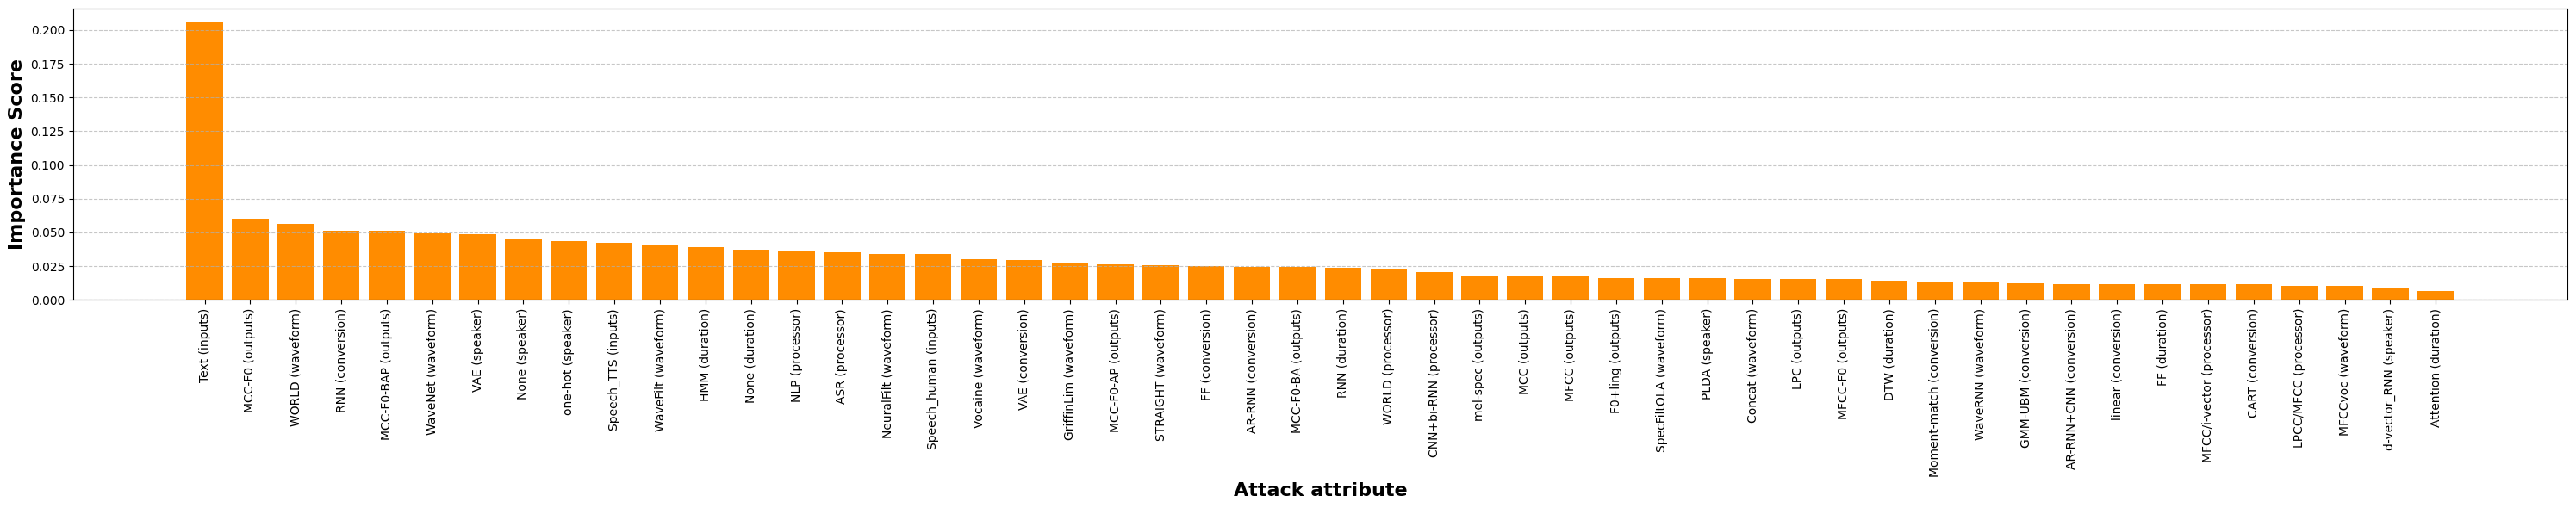

In [20]:
# Create a DataFrame for sorting
df = pd.DataFrame({'Feature': np.array(in_vars), 'Score': feature_scores})
df_sorted = df.sort_values(by='Score', ascending=False)

# Plot
plt.figure(figsize=(30, 6))
plt.bar(df_sorted['Feature'], df_sorted['Score'], color='darkorange')
plt.xticks(rotation=90)
plt.ylabel('Importance Score', fontsize=16, fontweight='bold')
plt.xlabel('Attack attribute', fontsize=16, fontweight='bold')
# plt.title('Feature Scores')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### **Intrinsic Interpretability - KAN with auxiliary model structure**

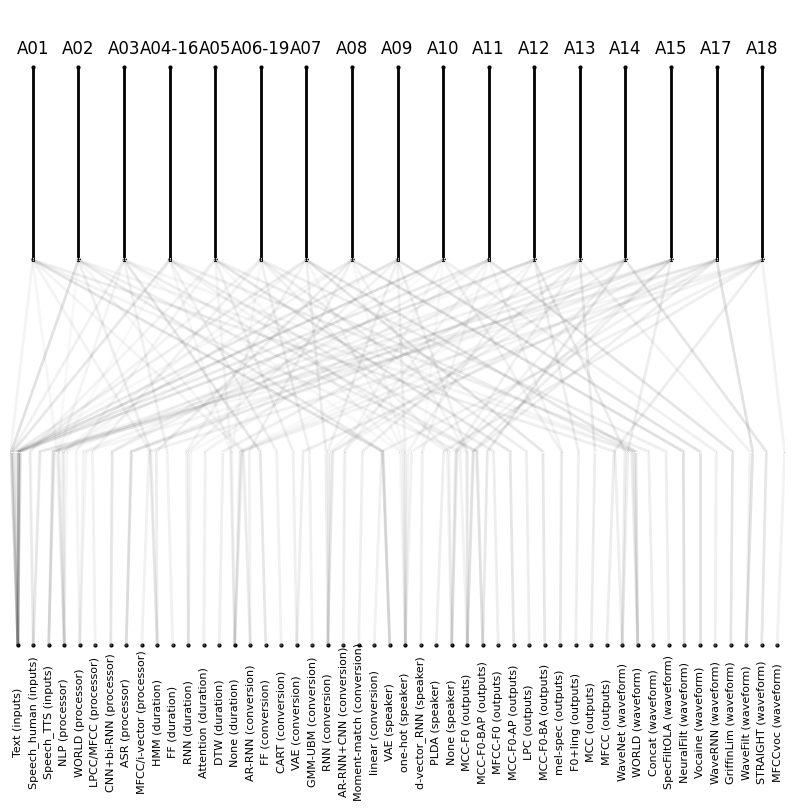

In [22]:
kan_module.plot(beta=3, scale=1, varscale=0.2, in_vars=in_vars, out_vars=out_vars)

**Per-class level FI**

In [25]:
def plot_inFeature_importance(kan_model, outNode_id):
    scores = kan_model.attribute(1, outNode_id)

    # Create a DataFrame for sorting
    df = pd.DataFrame({'Feature': np.array(in_vars), 'Score': scores.detach().cpu().numpy()})
    df_sorted = df.sort_values(by='Score', ascending=False)
    
    # Plot
    plt.figure(figsize=(30, 6))
    plt.bar(df_sorted['Feature'], df_sorted['Score'])
    plt.xticks(rotation=90)
    plt.ylabel('Feature Score')
    plt.title(''.format(outNode_id+1))
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

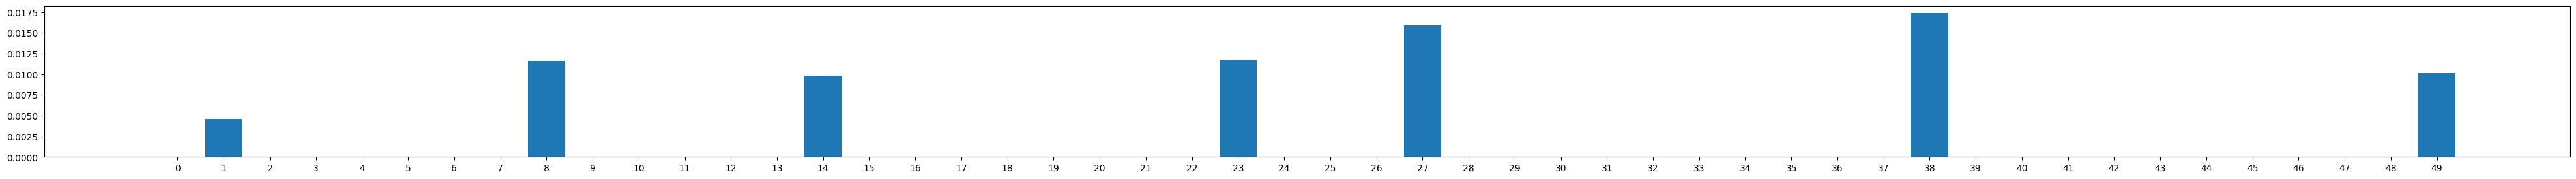

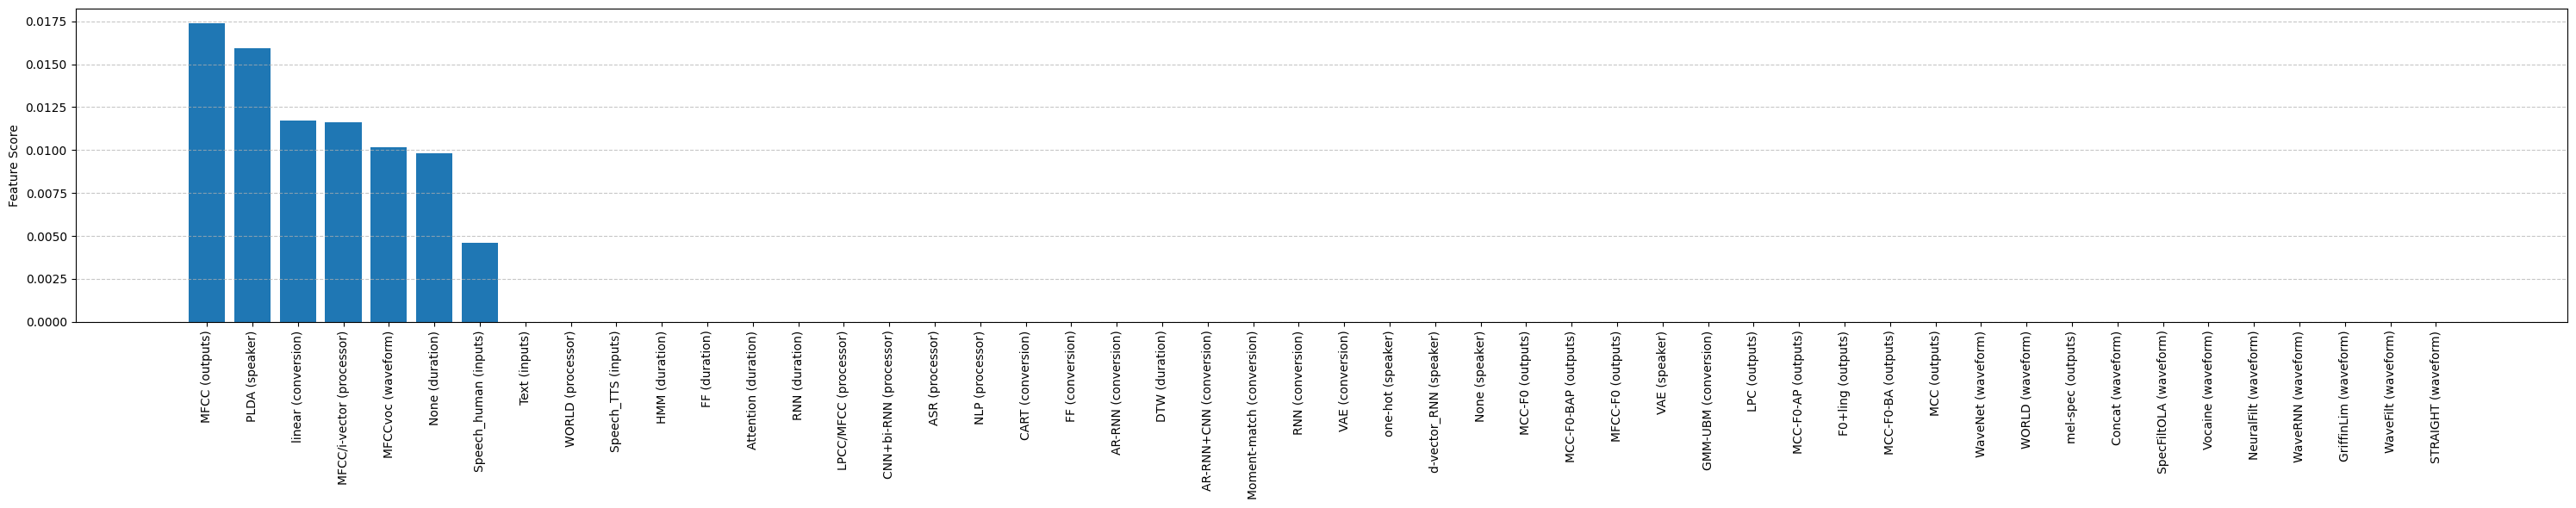

In [45]:
plot_inFeature_importance(kan_module, 16)

## **Feature Importance (FI) evaluation**

## **Criteria 1: Consistency**

### **Scenario 1: Different model weights trained with different initialization seed**

In [ ]:
import os
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.cm import ScalarMappable

from tqdm.auto import tqdm

import torch
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

from data_utils import ASVSpoof2019_Attr17_attack_attribute_structure
from model import CMMTLKAN
from FI_utils import *

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import balanced_accuracy_score

from itertools import combinations

**Utils**

In [4]:
in_vars=["Text (inputs)", "Speech_human (inputs)", "Speech_TTS (inputs)",
         "NLP (processor)", "WORLD (processor)", "LPCC/MFCC (processor)", "CNN+bi-RNN (processor)", "ASR (processor)", "MFCC/i-vector (processor)",
         "HMM (duration)", "FF (duration)", "RNN (duration)", "Attention (duration)", "DTW (duration)", "None (duration)", 
         "AR-RNN (conversion)", "FF (conversion)", "CART (conversion)", "VAE (conversion)", "GMM-UBM (conversion)", "RNN (conversion)", "AR-RNN+CNN (conversion)", "Moment-match (conversion)", "linear (conversion)",
         "VAE (speaker)", "one-hot (speaker)", "d-vector_RNN (speaker)", "PLDA (speaker)", "None (speaker)", 
         "MCC-F0 (outputs)", "MCC-F0-BAP (outputs)", "MFCC-F0 (outputs)", "MCC-F0-AP (outputs)", "LPC (outputs)", "MCC-F0-BA (outputs)", "mel-spec (outputs)", "F0+ling (outputs)", "MCC (outputs)", "MFCC (outputs)",
         "WaveNet (waveform)", "WORLD (waveform)", "Concat (waveform)", "SpecFiltOLA (waveform)", "NeuralFilt (waveform)", "Vocaine (waveform)", "WaveRNN (waveform)", "GriffinLim (waveform)", "WaveFilt (waveform)", "STRAIGHT (waveform)", "MFCCvoc (waveform)"
        ]
out_vars=['A01', 'A02', 'A03', 'A04-16', 'A05', 'A06-19', 'A07', 'A08', 'A09', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A17', 'A18']

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


**Evaluating**

In [102]:
embds_folder = "./extracted_embds"
exp_name = "ST_RB_AASIST_MTL_KANaux_trainingScratch_seed4321"
exp_folder = os.path.join(embds_folder, exp_name)

eval_attackAttr_embeddings_file = "ASVspoof2019_attr17_eval_attackAttr_embeddings.npy"

In [103]:
eval_attackAttr_embeddings_path = os.path.join(exp_folder, eval_attackAttr_embeddings_file)

In [104]:
eval_attackAttr_embeddings = np.load(eval_attackAttr_embeddings_path)
eval_attackAttr_embeddings.shape

(47880, 50)

In [105]:
eval_protocols_path = './data/ASVspoof2019_attr17_cm_protocols/Eval_ASVspoof19_attr17.txt'
eval_attack_labels = load_attack_labels(eval_protocols_path)

In [106]:
eval_dataset = AttClsDataset(eval_attackAttr_embeddings, eval_attack_labels)

In [107]:
eval_loader = DataLoader(eval_dataset,
                             batch_size=len(eval_dataset),
                             shuffle=False,
                             drop_last=False,
                             pin_memory=True,
                             collate_fn=None,
                             num_workers=8)
print("Number of batches in eval loader: ", len(eval_loader))

Number of batches in eval loader:  1


In [109]:
pretrained_path = "./weights/best_ST_RB_AASIST_MTL_KANaux_trainingScratch_seed4321.pt"
    
model = CMMTLKAN(
                backbone="AASIST",
                use_pretrained_backbone=False,
                freeze_backbone=False,
                device=device, 
                kan_auxiliary_structure=ASVSpoof2019_Attr17_attack_attribute_structure,
                seed=42
            ).to(device)
model.load_state_dict(torch.load(pretrained_path, map_location=device))
# model.kan_module.module_inFeatures(structure)

nb_params = sum([param.view(-1).size()[0] for param in model.parameters()])
print("no. model params:{}".format(nb_params))

Adding modular structure for KAN
no. model params:492444


In [110]:
kan_module = model.kan_module
# kan_module.module_inFeatures(structure)
kan_module.to(device)

MultKAN(
  (act_fun): ModuleList(
    (0): KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
)

In [111]:
eval_avg_acc, eval_avg_balanced_acc, attCls_cfsMatrix, attCls_clsReport = eval_AttackCls(eval_loader, kan_module, device)

  0%|          | 0/1 [00:00<?, ?it/s]

In [112]:
print("\nEvaluation Results:")
print("Average Accuracy:", eval_avg_acc)
print("Average Balanced Accuracy:", eval_avg_balanced_acc)
# print("\nAttack Classification Confusion Matrix:")
# plot_cfm(attCls_cfsMatrix, out_vars)
# print("\nAttack Classification Report:")
# print(attCls_clsReport)


Evaluation Results:
Average Accuracy: 0.9959482038429407
Average Balanced Accuracy: 0.9953409163437416


#### Whole model's FI

In [59]:
feature_scores = kan_module.feature_score.detach().cpu().numpy()
feature_scores

array([0.18253441, 0.04153369, 0.02895401, 0.03247824, 0.02847147,
       0.01343635, 0.01350343, 0.0407427 , 0.01244158, 0.02955857,
       0.01633012, 0.03647596, 0.01709592, 0.01185738, 0.02419281,
       0.03700736, 0.01689859, 0.01488475, 0.03286954, 0.01071379,
       0.04997308, 0.01546187, 0.01655702, 0.01415114, 0.04187078,
       0.05828444, 0.01412384, 0.0071792 , 0.03408142, 0.06831967,
       0.05539113, 0.01393391, 0.02365677, 0.01354242, 0.02458843,
       0.01348243, 0.0152939 , 0.01672952, 0.01271673, 0.0535581 ,
       0.06808367, 0.01376025, 0.01049767, 0.0293703 , 0.0284112 ,
       0.01535414, 0.02896049, 0.03127539, 0.02095802, 0.01044894],
      dtype=float32)

In [18]:
rank_FI_seed42= rank_feature_scores(feature_scores)
rank_FI_seed42

array([ 1, 17, 10, 14, 27, 47, 28, 15, 45, 12, 44, 26, 50, 38, 13, 24, 23,
       46, 19, 41,  4, 42, 39, 43,  7,  9, 49, 34,  8,  2,  5, 37, 21, 36,
       25, 29, 32, 30, 31,  6,  3, 35, 33, 16, 18, 40, 20, 11, 22, 48])

In [34]:
rank_FI_seed123= rank_feature_scores(feature_scores)
rank_FI_seed123

array([ 1, 17, 14, 11, 27, 47, 28, 15, 40, 13, 43, 21, 46, 34,  8, 19, 26,
       42, 18, 44,  5, 49, 39, 45,  7,  9, 48, 31, 10,  2,  4, 38, 23, 36,
       22, 32, 35, 29, 37,  6,  3, 33, 30, 16, 25, 41, 20, 12, 24, 50])

In [47]:
rank_FI_seed200= rank_feature_scores(feature_scores)
rank_FI_seed200

array([ 1,  9, 10, 15, 24, 42, 35, 18, 46, 22, 29, 14, 36, 45, 16, 19, 40,
       47, 13, 41,  5, 44, 39, 50,  2,  6, 48, 38, 17, 11,  3, 34, 20, 33,
       25, 23, 30, 28, 31,  8,  4, 37, 43, 12, 27, 49, 26,  7, 21, 32])

In [60]:
rank_FI_seed4321= rank_feature_scores(feature_scores)
rank_FI_seed4321

array([ 1,  9, 20, 15, 21, 43, 41, 10, 45, 17, 31, 12, 27, 46, 24, 11, 28,
       35, 14, 47,  7, 32, 30, 36,  8,  4, 37, 50, 13,  2,  5, 38, 25, 40,
       23, 42, 34, 29, 44,  6,  3, 39, 48, 18, 22, 33, 19, 16, 26, 49])

In [61]:
list_ranks = np.array([rank_FI_seed42, rank_FI_seed123, rank_FI_seed200, rank_FI_seed4321])
M = spearman_pairwise(list_ranks)
M

array([[1.        , 0.98060024, 0.89618247, 0.84086435],
       [0.98060024, 1.        , 0.89397359, 0.8495078 ],
       [0.89618247, 0.89397359, 1.        , 0.85373349],
       [0.84086435, 0.8495078 , 0.85373349, 1.        ]])

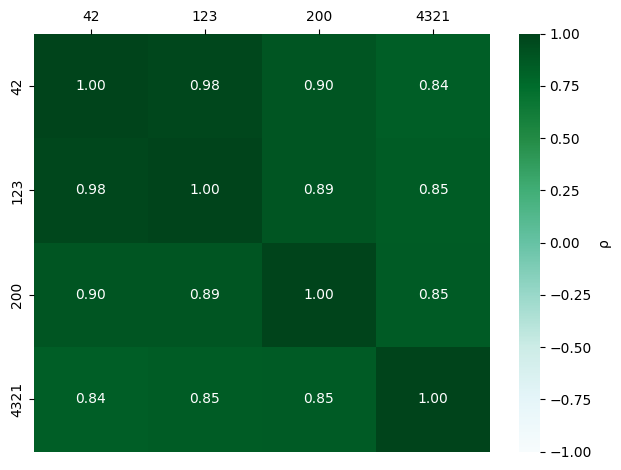

In [63]:
plot_corr_matrix(M, names=["42", "123", "200", "4321"], title="")

#### Per attack's FI

In [74]:
FI_perAtk_seed42 = get_FI_per_attack(kan_module)

In [86]:
FI_perAtk_seed123 = get_FI_per_attack(kan_module)

In [101]:
FI_perAtk_seed200 = get_FI_per_attack(kan_module)

In [113]:
FI_perAtk_seed4321 = get_FI_per_attack(kan_module)

In [114]:
list_runs = [FI_perAtk_seed42, FI_perAtk_seed123, FI_perAtk_seed200, FI_perAtk_seed4321]

In [115]:
list_M = []
for i in range(17):
    list_M.append(get_rank_perAtk_multi_runs(attack=i, list_runs=list_runs))
list_M = np.array(list_M)

In [116]:
list_M.shape

(17, 4, 4)

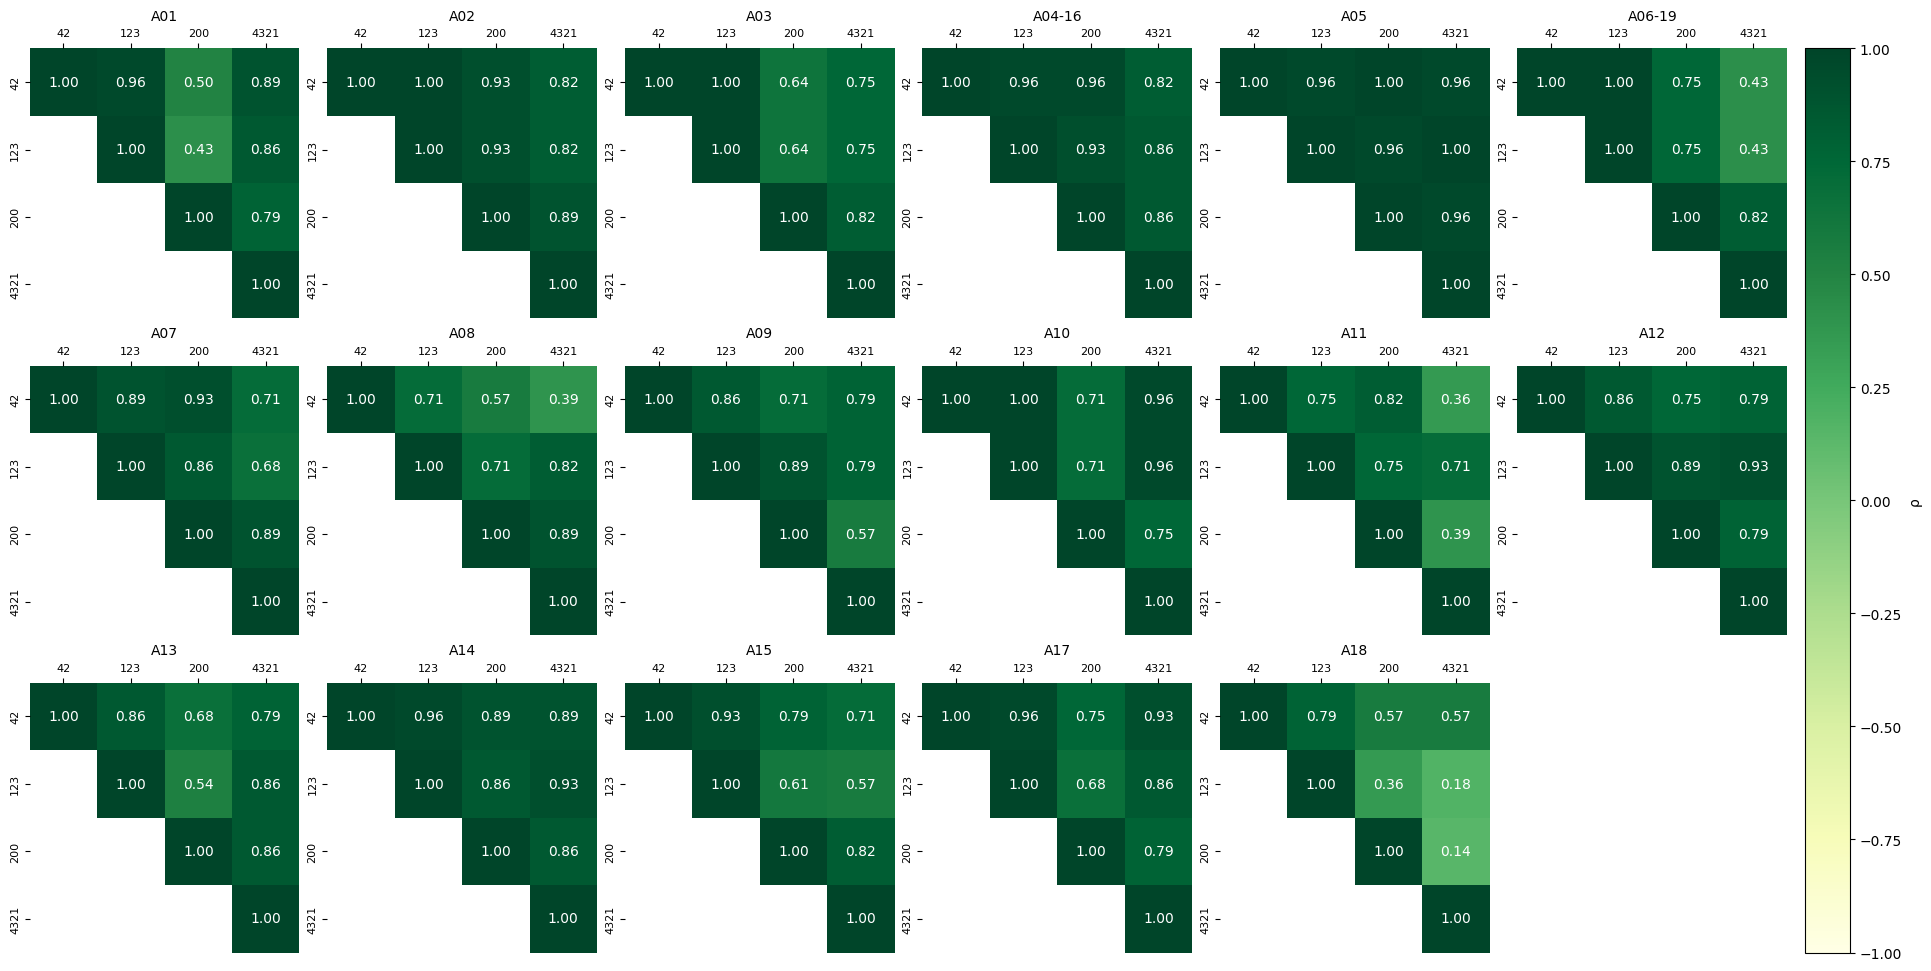

In [119]:
plot_corr_grid(list_M,
               titles=["A01", "A02", "A03", "A04-16", "A05", "A06-19", "A07", "A08", "A09", "A10", "A11", "A12", "A13", "A14", "A15", "A17", "A18"],
               seed_labels=["42", "123", "200", "4321"])

### **Scenario 2: Different model weights trained with different values of batch size**

In [ ]:
import os
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.cm import ScalarMappable

from tqdm.auto import tqdm

import torch
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

from data_utils import ASVSpoof2019_Attr17_attack_attribute_structure
from model import CMMTLKAN
from FI_utils import *

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import balanced_accuracy_score

from itertools import combinations

**Utils**

In [4]:
in_vars=["Text (inputs)", "Speech_human (inputs)", "Speech_TTS (inputs)",
         "NLP (processor)", "WORLD (processor)", "LPCC/MFCC (processor)", "CNN+bi-RNN (processor)", "ASR (processor)", "MFCC/i-vector (processor)",
         "HMM (duration)", "FF (duration)", "RNN (duration)", "Attention (duration)", "DTW (duration)", "None (duration)", 
         "AR-RNN (conversion)", "FF (conversion)", "CART (conversion)", "VAE (conversion)", "GMM-UBM (conversion)", "RNN (conversion)", "AR-RNN+CNN (conversion)", "Moment-match (conversion)", "linear (conversion)",
         "VAE (speaker)", "one-hot (speaker)", "d-vector_RNN (speaker)", "PLDA (speaker)", "None (speaker)", 
         "MCC-F0 (outputs)", "MCC-F0-BAP (outputs)", "MFCC-F0 (outputs)", "MCC-F0-AP (outputs)", "LPC (outputs)", "MCC-F0-BA (outputs)", "mel-spec (outputs)", "F0+ling (outputs)", "MCC (outputs)", "MFCC (outputs)",
         "WaveNet (waveform)", "WORLD (waveform)", "Concat (waveform)", "SpecFiltOLA (waveform)", "NeuralFilt (waveform)", "Vocaine (waveform)", "WaveRNN (waveform)", "GriffinLim (waveform)", "WaveFilt (waveform)", "STRAIGHT (waveform)", "MFCCvoc (waveform)"
        ]
out_vars=['A01', 'A02', 'A03', 'A04-16', 'A05', 'A06-19', 'A07', 'A08', 'A09', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A17', 'A18']

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


**Evaluating**

In [33]:
embds_folder = "./extracted_embds"
exp_name = "ST_RB_AASIST_MTL_KANaux_trainingScratch_seed42_bs64"
exp_folder = os.path.join(embds_folder, exp_name)

eval_attackAttr_embeddings_file = "ASVspoof2019_attr17_eval_attackAttr_embeddings.npy"

In [34]:
eval_attackAttr_embeddings_path = os.path.join(exp_folder, eval_attackAttr_embeddings_file)

In [35]:
eval_attackAttr_embeddings = np.load(eval_attackAttr_embeddings_path)
eval_attackAttr_embeddings.shape

(47880, 50)

In [36]:
eval_protocols_path = './data/ASVspoof2019_attr17_cm_protocols/Eval_ASVspoof19_attr17.txt'
eval_attack_labels = load_attack_labels(eval_protocols_path)

In [37]:
eval_dataset = AttClsDataset(eval_attackAttr_embeddings, eval_attack_labels)

In [38]:
eval_loader = DataLoader(eval_dataset,
                             batch_size=len(eval_dataset),
                             shuffle=False,
                             drop_last=False,
                             pin_memory=True,
                             collate_fn=None,
                             num_workers=4)
print("Number of batches in eval loader: ", len(eval_loader))

Number of batches in eval loader:  1


In [40]:
pretrained_path = "./weights/best_ST_RB_AASIST_MTL_KANaux_trainingScratch_seed42_bs64.pt"
    
model = CMMTLKAN(
                backbone="AASIST",
                use_pretrained_backbone=False,
                freeze_backbone=False,
                device=device, 
                kan_auxiliary_structure=ASVSpoof2019_Attr17_attack_attribute_structure,
                seed=42
            ).to(device)
model.load_state_dict(torch.load(pretrained_path, map_location=device))
# model.kan_module.module_inFeatures(structure)

nb_params = sum([param.view(-1).size()[0] for param in model.parameters()])
print("no. model params:{}".format(nb_params))

Adding modular structure for KAN
no. model params:492444


In [41]:
kan_module = model.kan_module
# kan_module.module_inFeatures(structure)
kan_module.to(device)

MultKAN(
  (act_fun): ModuleList(
    (0): KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
)

In [42]:
eval_avg_acc, eval_avg_balanced_acc, attCls_cfsMatrix, attCls_clsReport = eval_AttackCls(eval_loader, kan_module, device)

  0%|          | 0/1 [00:00<?, ?it/s]

In [43]:
print("\nEvaluation Results:")
print("Average Accuracy:", eval_avg_acc)
print("Average Balanced Accuracy:", eval_avg_balanced_acc)
# print("\nAttack Classification Confusion Matrix:")
# plot_cfm(attCls_cfsMatrix, out_vars)
# print("\nAttack Classification Report:")
# print(attCls_clsReport)


Evaluation Results:
Average Accuracy: 0.995342522974102
Average Balanced Accuracy: 0.9947281396939731


#### Whole model's FI

In [43]:
feature_scores = kan_module.feature_score.detach().cpu().numpy()
feature_scores

array([0.23529978, 0.04155416, 0.0537554 , 0.04484247, 0.02923093,
       0.01160986, 0.02505994, 0.04010738, 0.0151801 , 0.04406211,
       0.01229886, 0.03452374, 0.01418981, 0.01839625, 0.03558631,
       0.0281763 , 0.02061979, 0.01037083, 0.02771552, 0.00982827,
       0.05406925, 0.01246074, 0.01134874, 0.01021362, 0.04829556,
       0.06097243, 0.0160869 , 0.02323977, 0.05632228, 0.06727294,
       0.04953805, 0.01413076, 0.01944949, 0.01640442, 0.01919111,
       0.01458014, 0.01416838, 0.01438359, 0.01456166, 0.04400059,
       0.05792749, 0.01465277, 0.01598229, 0.02247619, 0.01735082,
       0.01014906, 0.01947434, 0.03468499, 0.0198007 , 0.00794627],
      dtype=float32)

In [17]:
rank_FI_bs16= rank_feature_scores(feature_scores)
rank_FI_bs16

array([ 1, 17, 10, 14, 27, 47, 28, 15, 45, 12, 44, 26, 50, 38, 13, 24, 23,
       46, 19, 41,  4, 42, 39, 43,  7,  9, 49, 34,  8,  2,  5, 37, 21, 36,
       25, 29, 32, 30, 31,  6,  3, 35, 33, 16, 18, 40, 20, 11, 22, 48])

In [31]:
rank_FI_bs32= rank_feature_scores(feature_scores)
rank_FI_bs32

array([ 1, 15,  7, 10, 20, 41, 22, 12, 35, 14, 43, 19, 49, 29, 11, 21, 23,
       45, 18, 47,  4, 42, 40, 46,  8,  9, 50, 30, 13,  2,  5, 39, 25, 31,
       28, 36, 32, 33, 38,  6,  3, 34, 37, 17, 27, 44, 26, 16, 24, 48])

In [44]:
rank_FI_bs64 = rank_feature_scores(feature_scores)
rank_FI_bs64

array([ 1, 13,  7, 10, 18, 44, 21, 14, 34, 11, 43, 17, 39, 29, 15, 19, 24,
       46, 20, 49,  6, 42, 45, 47,  9,  3, 32, 22,  5,  2,  8, 41, 27, 31,
       28, 36, 40, 38, 37, 12,  4, 35, 33, 23, 30, 48, 26, 16, 25, 50])

In [45]:
list_ranks = np.array([rank_FI_bs16, rank_FI_bs32, rank_FI_bs64])
M = spearman_pairwise(list_ranks)
M

array([[1.        , 0.95966387, 0.90895558],
       [0.95966387, 1.        , 0.95620648],
       [0.90895558, 0.95620648, 1.        ]])

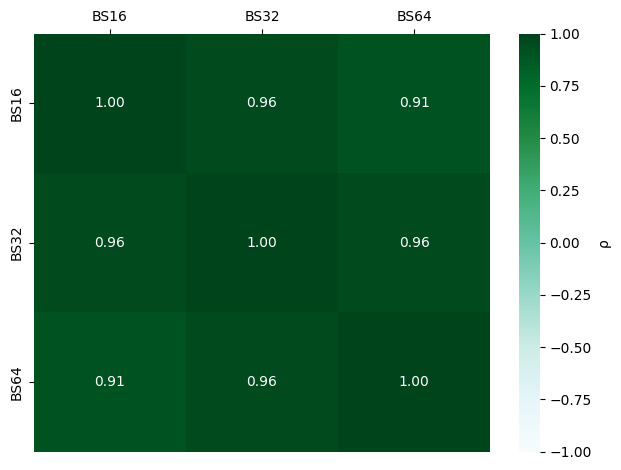

In [47]:
plot_corr_matrix(M, names=["BS16", "BS32", "BS64"], title="")

#### Per attack's FI

In [20]:
FI_perAtk_bs16 = get_FI_per_attack(kan_module)

In [32]:
FI_perAtk_bs32 = get_FI_per_attack(kan_module)

In [44]:
FI_perAtk_bs64 = get_FI_per_attack(kan_module)

In [45]:
list_runs = [FI_perAtk_bs16, FI_perAtk_bs32, FI_perAtk_bs64]

In [46]:
list_M = []
for i in range(17):
    list_M.append(get_rank_perAtk_multi_runs(attack=i, list_runs=list_runs))
list_M = np.array(list_M)

In [47]:
list_M.shape

(17, 3, 3)

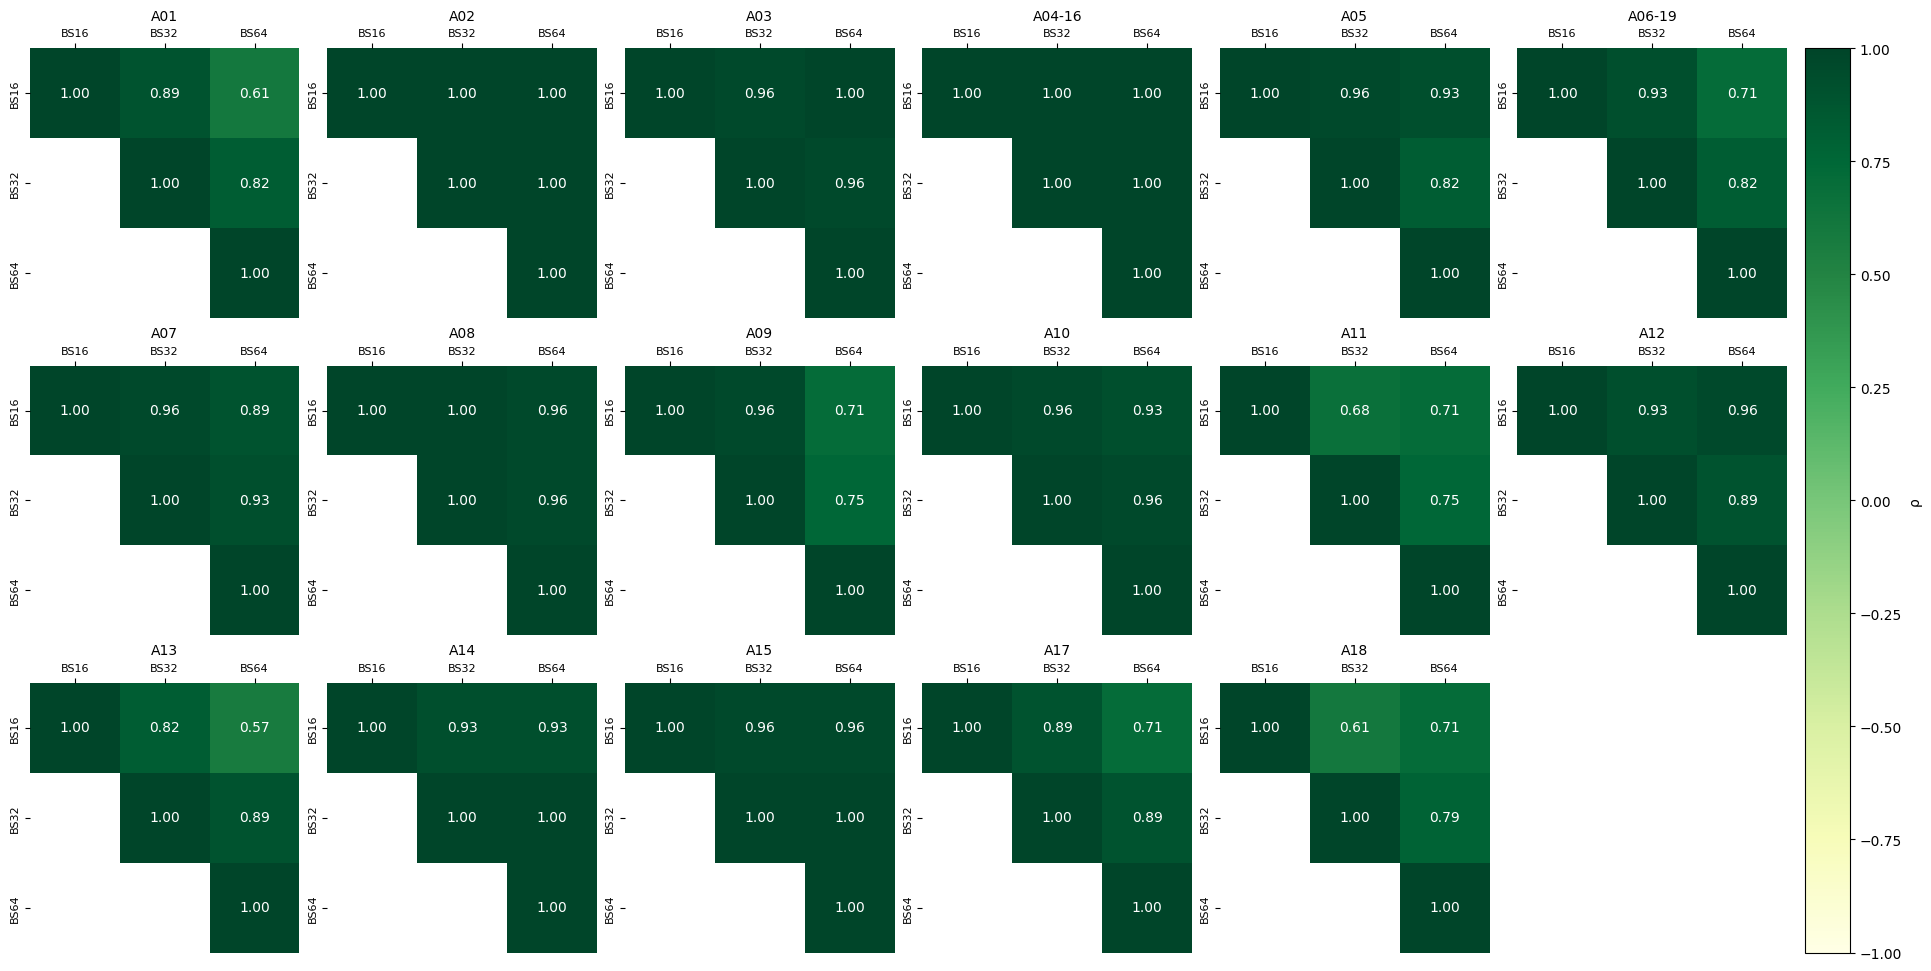

In [49]:
plot_corr_grid(list_M,
               titles=["A01", "A02", "A03", "A04-16", "A05", "A06-19", "A07", "A08", "A09", "A10", "A11", "A12", "A13", "A14", "A15", "A17", "A18"],
               seed_labels=["BS16", "BS32", "BS64"])

### **Scenario 3: Different model weights trained with different architecture and training scenario**

In [ ]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

import torch
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

from data_utils import ASVSpoof2019_Attr17_attack_attribute_structure
from model import CMMTLKAN
from FI_utils import *


**Utils**

In [4]:
in_vars=["Text (inputs)", "Speech_human (inputs)", "Speech_TTS (inputs)",
         "NLP (processor)", "WORLD (processor)", "LPCC/MFCC (processor)", "CNN+bi-RNN (processor)", "ASR (processor)", "MFCC/i-vector (processor)",
         "HMM (duration)", "FF (duration)", "RNN (duration)", "Attention (duration)", "DTW (duration)", "None (duration)", 
         "AR-RNN (conversion)", "FF (conversion)", "CART (conversion)", "VAE (conversion)", "GMM-UBM (conversion)", "RNN (conversion)", "AR-RNN+CNN (conversion)", "Moment-match (conversion)", "linear (conversion)",
         "VAE (speaker)", "one-hot (speaker)", "d-vector_RNN (speaker)", "PLDA (speaker)", "None (speaker)", 
         "MCC-F0 (outputs)", "MCC-F0-BAP (outputs)", "MFCC-F0 (outputs)", "MCC-F0-AP (outputs)", "LPC (outputs)", "MCC-F0-BA (outputs)", "mel-spec (outputs)", "F0+ling (outputs)", "MCC (outputs)", "MFCC (outputs)",
         "WaveNet (waveform)", "WORLD (waveform)", "Concat (waveform)", "SpecFiltOLA (waveform)", "NeuralFilt (waveform)", "Vocaine (waveform)", "WaveRNN (waveform)", "GriffinLim (waveform)", "WaveFilt (waveform)", "STRAIGHT (waveform)", "MFCCvoc (waveform)"
        ]
out_vars=['A01', 'A02', 'A03', 'A04-16', 'A05', 'A06-19', 'A07', 'A08', 'A09', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A17', 'A18']

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


**Evaluating**

In [53]:
embds_folder = "./extracted_embds"
exp_name = "ST_RB_SSLAASIST_MTL_KANaux_partialFinetuning"
exp_folder = os.path.join(embds_folder, exp_name)

eval_attackAttr_embeddings_file = "ASVspoof2019_attr17_eval_attackAttr_embeddings.npy"

In [54]:
eval_attackAttr_embeddings_path = os.path.join(exp_folder, eval_attackAttr_embeddings_file)

In [55]:
eval_attackAttr_embeddings = np.load(eval_attackAttr_embeddings_path)
eval_attackAttr_embeddings.shape

(47880, 50)

In [56]:
eval_protocols_path = './data/ASVspoof2019_attr17_cm_protocols/Eval_ASVspoof19_attr17.txt'
eval_attack_labels = load_attack_labels(eval_protocols_path)

In [57]:
eval_dataset = AttClsDataset(eval_attackAttr_embeddings, eval_attack_labels)

In [58]:
eval_loader = DataLoader(eval_dataset,
                             batch_size=len(eval_dataset),
                             shuffle=False,
                             drop_last=False,
                             pin_memory=True,
                             collate_fn=None,
                             num_workers=4)
print("Number of batches in eval loader: ", len(eval_loader))

Number of batches in eval loader:  1


In [60]:
pretrained_path = "./weights/best_ST_RB_SSLAASIST_MTL_KANaux_partialFinetuning.pt"
    
model = CMMTLKAN(
                backbone="SSLAASIST",
                use_pretrained_backbone=False,
                freeze_backbone=False,
                device=device, 
                kan_auxiliary_structure=ASVSpoof2019_Attr17_attack_attribute_structure,
                seed=42
            ).to(device)
model.load_state_dict(torch.load(pretrained_path, map_location=device))
# model.kan_module.module_inFeatures(structure)

nb_params = sum([param.view(-1).size()[0] for param in model.parameters()])
print("no. model params:{}".format(nb_params))

Adding modular structure for KAN
no. model params:318032412


In [61]:
kan_module = model.kan_module
# kan_module.module_inFeatures(structure)
kan_module.to(device)

MultKAN(
  (act_fun): ModuleList(
    (0): KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
)

In [62]:
eval_avg_acc, eval_avg_balanced_acc, attCls_cfsMatrix, attCls_clsReport = eval_AttackCls(eval_loader, kan_module, device)

  0%|          | 0/1 [00:00<?, ?it/s]

In [63]:
print("\nEvaluation Results:")
print("Average Accuracy:", eval_avg_acc)
print("Average Balanced Accuracy:", eval_avg_balanced_acc)
# print("\nAttack Classification Confusion Matrix:")
# plot_cfm(attCls_cfsMatrix, out_vars)
# print("\nAttack Classification Report:")
# print(attCls_clsReport)


Evaluation Results:
Average Accuracy: 0.6480367585630743
Average Balanced Accuracy: 0.6170888718050037


#### Whole model's FI

In [68]:
feature_scores = kan_module.feature_score.detach().cpu().numpy()
feature_scores

array([0.10074423, 0.09013731, 0.01685512, 0.03157819, 0.02377163,
       0.01181546, 0.02187432, 0.04308654, 0.01096203, 0.02293944,
       0.00883454, 0.02036311, 0.0125485 , 0.01516474, 0.03329991,
       0.04077283, 0.01575874, 0.01712437, 0.03833323, 0.00818607,
       0.07894762, 0.02977885, 0.01736995, 0.00897409, 0.04614152,
       0.09913014, 0.00573651, 0.0111661 , 0.0302335 , 0.05545405,
       0.0675772 , 0.01802883, 0.01891338, 0.00863943, 0.02266382,
       0.02273944, 0.01854711, 0.01766826, 0.01239186, 0.05326113,
       0.03448028, 0.01810144, 0.00383708, 0.02936223, 0.02499278,
       0.01569604, 0.01224187, 0.00693721, 0.01780662, 0.00207055],
      dtype=float32)

In [17]:
rank_FI_AASIST_ts= rank_feature_scores(feature_scores)
rank_FI_AASIST_ts

array([ 1, 17, 10, 14, 27, 47, 28, 15, 45, 12, 44, 26, 50, 38, 13, 24, 23,
       46, 19, 41,  4, 42, 39, 43,  7,  9, 49, 34,  8,  2,  5, 37, 21, 36,
       25, 29, 32, 30, 31,  6,  3, 35, 33, 16, 18, 40, 20, 11, 22, 48])

In [30]:
rank_FI_AASIST_ff= rank_feature_scores(feature_scores)
rank_FI_AASIST_ff

array([ 1, 24, 10,  9, 26, 47, 27, 12, 32, 14, 39, 16, 45, 36,  6, 25, 28,
       44, 15, 46,  4, 48, 40, 43,  7, 18, 50, 37, 11,  2,  5, 33, 22, 29,
       20, 34, 41, 31, 35,  8,  3, 38, 30, 17, 19, 42, 23, 13, 21, 49])

In [43]:
rank_FI_AASIST_pf= rank_feature_scores(feature_scores)
rank_FI_AASIST_pf

array([ 1, 16,  3,  9, 10, 42, 35, 17, 38, 22, 47, 31, 50, 49,  2, 11, 27,
       43, 13, 44,  4, 39, 24, 40, 15,  8, 19, 21,  7,  5,  6, 26, 36, 37,
       23, 46, 30, 28, 45, 14, 12, 33, 41, 20, 34, 29, 18, 25, 32, 48])

In [56]:
rank_FI_SSLAASIST_ff= rank_feature_scores(feature_scores)
rank_FI_SSLAASIST_ff

array([ 1,  5, 17, 11, 12, 42, 40, 22, 27,  9, 50, 21, 37, 41,  7, 23, 20,
       44, 24, 46, 15, 39, 31, 43, 16, 10, 49, 47,  8,  2,  4, 38, 29, 35,
       19, 36, 28, 32, 45,  6,  3, 30, 33, 14, 13, 34, 26, 18, 25, 48])

In [69]:
rank_FI_SSLAASIST_pf= rank_feature_scores(feature_scores)
rank_FI_SSLAASIST_pf

array([ 1,  3, 33, 14, 19, 40, 23,  9, 42, 20, 44, 24, 37, 36, 13, 10, 34,
       32, 11, 46,  4, 16, 31, 43,  8,  2, 48, 41, 15,  6,  5, 28, 25, 45,
       22, 21, 26, 30, 38,  7, 12, 27, 49, 17, 18, 35, 39, 47, 29, 50])

In [70]:
list_ranks = np.array([rank_FI_AASIST_ts, rank_FI_AASIST_ff, rank_FI_AASIST_pf, rank_FI_SSLAASIST_ff, rank_FI_SSLAASIST_pf])
M = spearman_pairwise(list_ranks)
M

array([[1.        , 0.95553421, 0.79620648, 0.88888355, 0.75366146],
       [0.95553421, 1.        , 0.77478992, 0.87995198, 0.70804322],
       [0.79620648, 0.77478992, 1.        , 0.79159664, 0.69488595],
       [0.88888355, 0.87995198, 0.79159664, 1.        , 0.77382953],
       [0.75366146, 0.70804322, 0.69488595, 0.77382953, 1.        ]])

In [73]:
def plot_corr_matrix(M, names=None, title="Spearman rank correlation"):
    m = len(M)
    if names is None: names = [f"V{i+1}" for i in range(m)]
    df = pd.DataFrame(M, index=names, columns=names)
    # mask = np.tril(np.ones_like(df, dtype=bool), k=-1)  # hide strictly lower
    ax = sns.heatmap(df, vmin=-1, vmax=1, annot=True, fmt=".2f",
                     cbar_kws={'label': 'ρ'}, cmap='BuGn')
    ax.set_title(title)
    ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    plt.tight_layout()
    plt.show()

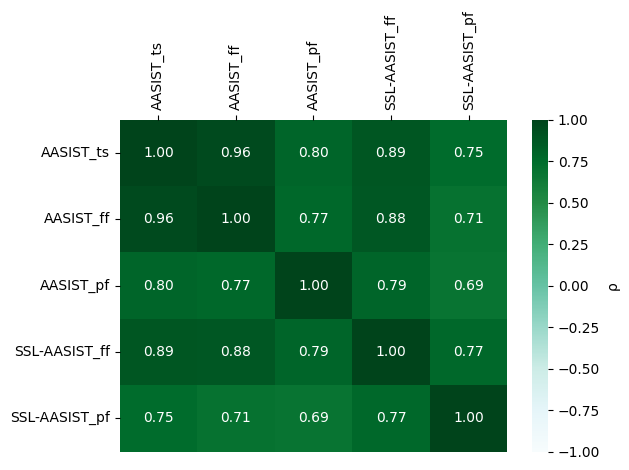

In [74]:
plot_corr_matrix(M, names=["AASIST_ts", "AASIST_ff", "AASIST_pf", "SSL-AASIST_ff", "SSL-AASIST_pf"], title="")

#### Per attack's FI

In [16]:
FI_perAtk_AASIST_ts = get_FI_per_attack(kan_module)

In [28]:
FI_perAtk_AASIST_ff = get_FI_per_attack(kan_module)

In [40]:
FI_perAtk_AASIST_pf = get_FI_per_attack(kan_module)

In [52]:
FI_perAtk_SSLAASIST_ff = get_FI_per_attack(kan_module)

In [64]:
FI_perAtk_SSLAASIST_pf = get_FI_per_attack(kan_module)

In [65]:
list_runs = [FI_perAtk_AASIST_ts, FI_perAtk_AASIST_ff, FI_perAtk_AASIST_pf, FI_perAtk_SSLAASIST_ff, FI_perAtk_SSLAASIST_pf]

In [66]:
list_M = []
for i in range(17):
    list_M.append(get_rank_perAtk_multi_runs(attack=i, list_runs=list_runs))
list_M = np.array(list_M)

In [67]:
list_M.shape

(17, 5, 5)

In [68]:
def plot_corr_grid(M_list, titles=None, names=None, upper_only=True,
                   cmap="YlGn", annot=True, fmt=".2f"):
    
    k = len(M_list)
    N = M_list[0].shape[0]
    assert all(M.shape == (N, N) for M in M_list), "All matrices must be same size."

    if titles is None:
        titles = [f"A{i+1:02d}" for i in range(k)]
    if names is None:
        names = [str(i+1) for i in range(N)]

    # choose a compact grid
    cols = min(6, k)                    # up to 5 across; adjust if you prefer
    rows = math.ceil(k / cols)

    fig, axes = plt.subplots(rows, cols,
                             figsize=(cols*3.2, rows*3.2),
                             constrained_layout=True)
    axes = np.atleast_1d(axes).ravel()

    vmin, vmax = -1.0, 1.0
    norm = plt.Normalize(vmin=vmin, vmax=vmax)

    for ax, M, title in zip(axes, M_list, titles):
        df = pd.DataFrame(M, index=names, columns=names)
        mask = np.tril(np.ones_like(df, dtype=bool), k=-1) if upper_only else None
        sns.heatmap(df, ax=ax, cmap=cmap, vmin=vmin, vmax=vmax,
                    square=True, mask=mask, annot=annot, fmt=fmt,
                    cbar=False)
        ax.set_title(title, pad=6, fontsize=10)
        ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False, labelsize=8)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

    # hide any unused axes
    for ax in axes[len(M_list):]:
        ax.axis("off")

    # one shared colorbar
    sm = ScalarMappable(norm=norm, cmap=cmap); sm.set_array([])
    cbar = fig.colorbar(sm, ax=axes[:len(M_list)], fraction=0.03, pad=0.01)
    cbar.set_label("ρ")

    plt.show()

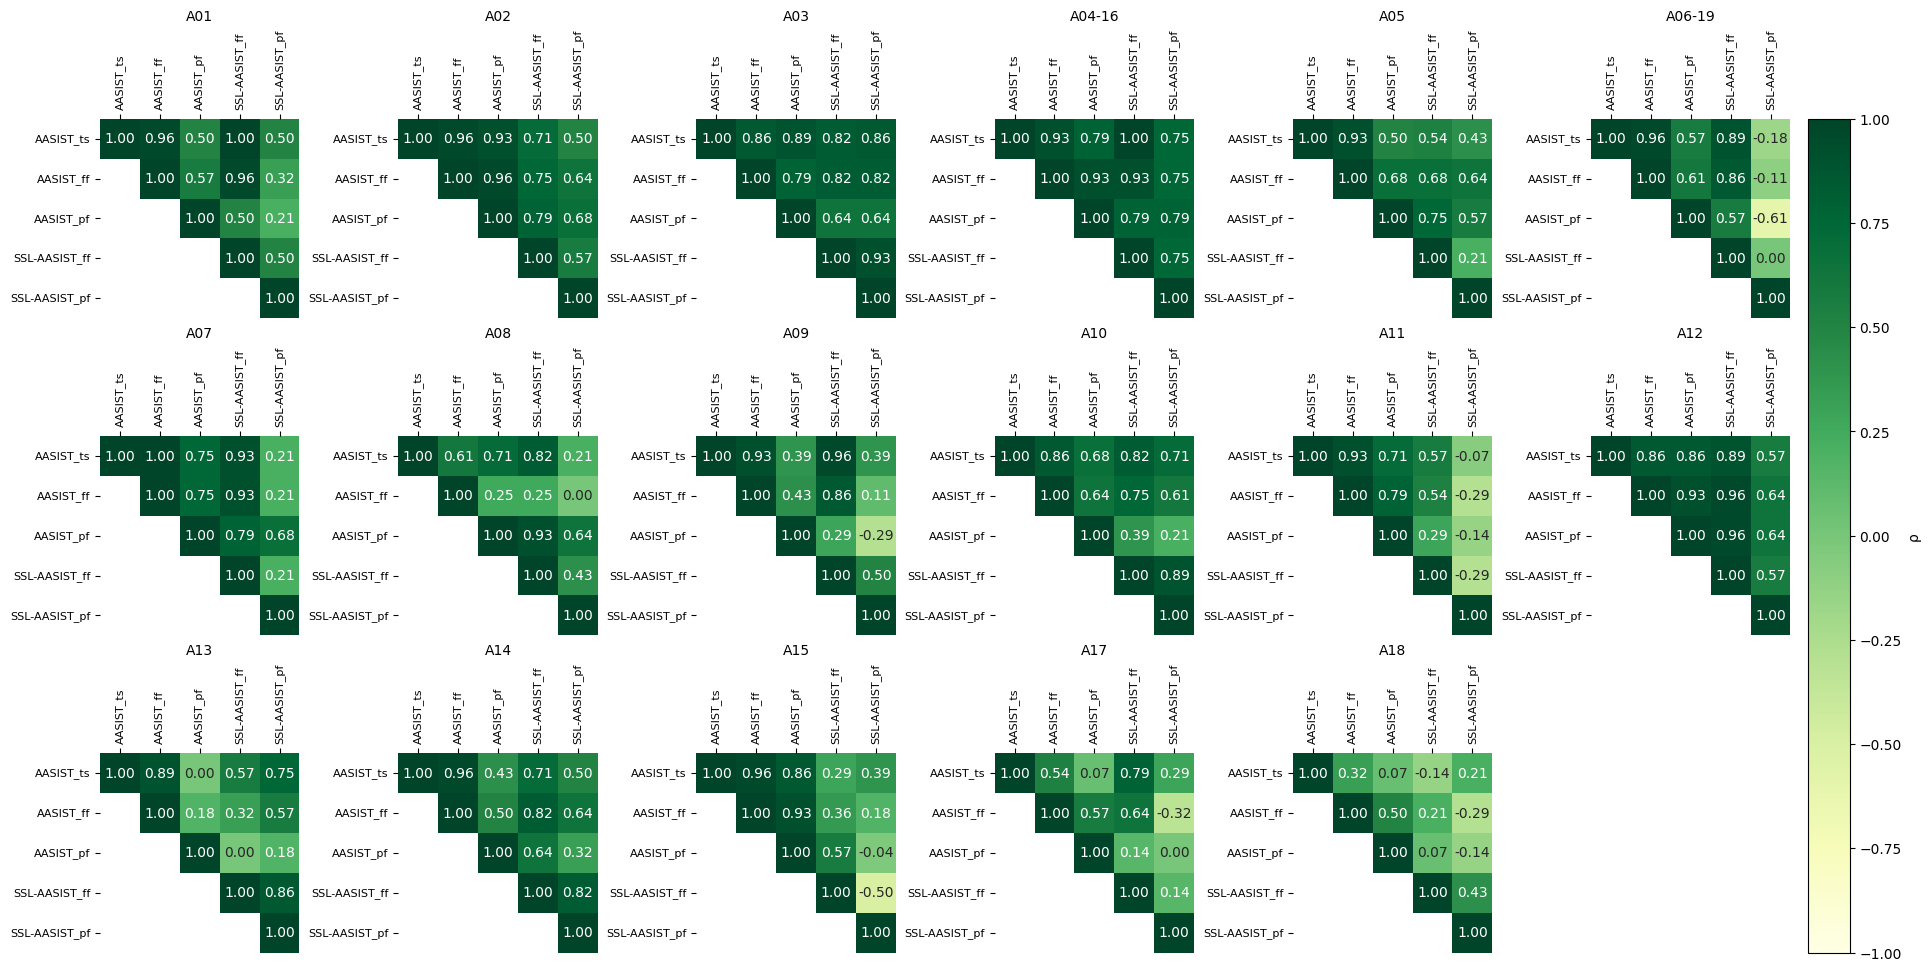

In [70]:
plot_corr_grid(list_M,
               titles=["A01", "A02", "A03", "A04-16", "A05", "A06-19", "A07", "A08", "A09", "A10", "A11", "A12", "A13", "A14", "A15", "A17", "A18"],
               names=["AASIST_ts", "AASIST_ff", "AASIST_pf", "SSL-AASIST_ff", "SSL-AASIST_pf"])

### **Scenario 4: Different FI methods**

In [ ]:
import os
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.cm import ScalarMappable

from tqdm.auto import tqdm

import torch
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

from data_utils import ASVSpoof2019_Attr17_attack_attribute_structure
from model import CMMTLKAN
from FI_utils import *

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import balanced_accuracy_score

from itertools import combinations


**Utils**

In [7]:
def eval_AttackCls(loader, model, device):

    model.eval()

    total_acc = 0.0
    
    all_true = []
    all_pred = []
    
    total = 0

    with torch.no_grad():
        for embeddings, attack_labels in tqdm(loader):
            
            embeddings = embeddings.to(device)
            attack_labels = attack_labels.to(device)
            
            AttackCls_outputs = model(embeddings)
            
            total += embeddings.shape[0]
            
            AttackCls_probs = F.softmax(AttackCls_outputs, dim=-1) # [B, n_attack_types]
            pred_AttackCls = AttackCls_probs.argmax(dim=-1)  # [B]
            AttackCls_acc = (pred_AttackCls == attack_labels).float().sum().item()  # acc for 1 batch of #n_spoof_samples_in_a_batch
            total_acc += AttackCls_acc
            
            # used for balanced accuracy
            pred_AttackCls = pred_AttackCls.cpu().numpy()
            true_AttackCls = attack_labels.cpu().numpy()
            all_pred.extend(pred_AttackCls)
            all_true.extend(true_AttackCls)
            
    avg_acc = total_acc / total
    
    # balanced accuracy
    avg_balanced_acc = balanced_accuracy_score(all_true, all_pred)

    attCls_cfsMatrix = confusion_matrix(all_true, all_pred)
    attCls_clsReport = classification_report(all_true, all_pred, digits=3)
    
    return avg_acc, avg_balanced_acc, attCls_cfsMatrix, attCls_clsReport 

In [8]:
in_vars=["Text (inputs)", "Speech_human (inputs)", "Speech_TTS (inputs)",
         "NLP (processor)", "WORLD (processor)", "LPCC/MFCC (processor)", "CNN+bi-RNN (processor)", "ASR (processor)", "MFCC/i-vector (processor)",
         "HMM (duration)", "FF (duration)", "RNN (duration)", "Attention (duration)", "DTW (duration)", "None (duration)", 
         "AR-RNN (conversion)", "FF (conversion)", "CART (conversion)", "VAE (conversion)", "GMM-UBM (conversion)", "RNN (conversion)", "AR-RNN+CNN (conversion)", "Moment-match (conversion)", "linear (conversion)",
         "VAE (speaker)", "one-hot (speaker)", "d-vector_RNN (speaker)", "PLDA (speaker)", "None (speaker)", 
         "MCC-F0 (outputs)", "MCC-F0-BAP (outputs)", "MFCC-F0 (outputs)", "MCC-F0-AP (outputs)", "LPC (outputs)", "MCC-F0-BA (outputs)", "mel-spec (outputs)", "F0+ling (outputs)", "MCC (outputs)", "MFCC (outputs)",
         "WaveNet (waveform)", "WORLD (waveform)", "Concat (waveform)", "SpecFiltOLA (waveform)", "NeuralFilt (waveform)", "Vocaine (waveform)", "WaveRNN (waveform)", "GriffinLim (waveform)", "WaveFilt (waveform)", "STRAIGHT (waveform)", "MFCCvoc (waveform)"
        ]
out_vars=['A01', 'A02', 'A03', 'A04-16', 'A05', 'A06-19', 'A07', 'A08', 'A09', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A17', 'A18']

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


### **Built-in KAN FI**

In [10]:
embds_folder = "./extracted_embds"
exp_name = "ST_RB_AASIST_MTL_KANaux_trainingScratch"
exp_folder = os.path.join(embds_folder, exp_name)

eval_attackAttr_embeddings_file = "ASVspoof2019_attr17_eval_attackAttr_embeddings.npy"

In [11]:
eval_attackAttr_embeddings_path = os.path.join(exp_folder, eval_attackAttr_embeddings_file)

In [12]:
eval_attackAttr_embeddings = np.load(eval_attackAttr_embeddings_path)
eval_attackAttr_embeddings.shape

(47880, 50)

In [13]:
eval_protocols_path = './data/ASVspoof2019_attr17_cm_protocols/Eval_ASVspoof19_attr17.txt'
eval_attack_labels = load_attack_labels(eval_protocols_path)

In [14]:
eval_dataset = AttClsDataset(eval_attackAttr_embeddings, eval_attack_labels)

In [15]:
eval_loader = DataLoader(eval_dataset,
                             batch_size=len(eval_dataset),
                             shuffle=False,
                             drop_last=False,
                             pin_memory=True,
                             collate_fn=None,
                             num_workers=8)
print("Number of batches in eval loader: ", len(eval_loader))

Number of batches in eval loader:  1


In [16]:
pretrained_path = "./weights/best_ST_RB_AASIST_MTL_KANaux_trainingScratch.pt"
    
model = CMMTLKAN(
                backbone="AASIST",
                use_pretrained_backbone=False,
                freeze_backbone=False,
                device=device, 
                kan_auxiliary_structure=ASVSpoof2019_Attr17_attack_attribute_structure,
                seed=42
            ).to(device)
model.load_state_dict(torch.load(pretrained_path, map_location=device))
# model.kan_module.module_inFeatures(structure)

nb_params = sum([param.view(-1).size()[0] for param in model.parameters()])
print("no. model params:{}".format(nb_params))

Adding modular structure for KAN
no. model params:492444


In [17]:
kan_module = model.kan_module
# kan_module.module_inFeatures(structure)
kan_module.to(device)

MultKAN(
  (act_fun): ModuleList(
    (0): KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
)

In [18]:
eval_avg_acc, eval_avg_balanced_acc, attCls_cfsMatrix, attCls_clsReport = eval_AttackCls(eval_loader, kan_module, device)

  0%|          | 0/1 [00:00<?, ?it/s]

In [19]:
print("\nEvaluation Results:")
print("Average Accuracy:", eval_avg_acc)
print("Average Balanced Accuracy:", eval_avg_balanced_acc)
# print("\nAttack Classification Confusion Matrix:")
# plot_cfm(attCls_cfsMatrix, out_vars)
# print("\nAttack Classification Report:")
# print(attCls_clsReport)


Evaluation Results:
Average Accuracy: 0.9959899749373433
Average Balanced Accuracy: 0.9952779692968117


In [20]:
kan_module.cache_data.shape

torch.Size([47880, 50])

In [21]:
feature_scores = kan_module.feature_score
feature_scores

tensor([0.2056, 0.0341, 0.0425, 0.0362, 0.0223, 0.0103, 0.0208, 0.0351, 0.0116,
        0.0390, 0.0116, 0.0236, 0.0063, 0.0140, 0.0370, 0.0247, 0.0250, 0.0115,
        0.0292, 0.0123, 0.0513, 0.0118, 0.0136, 0.0117, 0.0485, 0.0438, 0.0086,
        0.0159, 0.0455, 0.0599, 0.0512, 0.0153, 0.0266, 0.0155, 0.0246, 0.0179,
        0.0160, 0.0176, 0.0174, 0.0495, 0.0563, 0.0156, 0.0160, 0.0342, 0.0300,
        0.0127, 0.0272, 0.0408, 0.0257, 0.0101], device='cuda:0',
       grad_fn=<MeanBackward1>)

### **evaluating whole data's FI**

In [22]:
KAN_builtin_FI = kan_module.feature_score.detach().cpu().numpy()
KAN_builtin_FI

array([0.20562686, 0.03405593, 0.04245324, 0.03617182, 0.02231999,
       0.0103405 , 0.02076587, 0.03514146, 0.01164321, 0.03897751,
       0.01164634, 0.02355151, 0.00633507, 0.01404929, 0.03701304,
       0.02465292, 0.0250267 , 0.01152082, 0.0292038 , 0.01229984,
       0.05129093, 0.01184083, 0.01361861, 0.01171748, 0.04847642,
       0.04377294, 0.00864215, 0.01590724, 0.04545281, 0.05985686,
       0.0512073 , 0.01531271, 0.02655103, 0.01547225, 0.02456337,
       0.01789828, 0.0160277 , 0.01757327, 0.01736732, 0.0495399 ,
       0.05634766, 0.01560541, 0.01595636, 0.03417489, 0.02999453,
       0.01270396, 0.02717767, 0.04080744, 0.0257196 , 0.01014895],
      dtype=float32)

#### **KAN + SHAP FI**

In [ ]:
!python get_shap_FIscores.py

In [23]:
import pickle

shap_FI_file = "./shap_values/shap_values_AASIST_MTL_KANaux.pkl"

shap_FI = pickle.load(open(shap_FI_file, 'rb'))

In [26]:
shap_FI.shape

(47880, 50, 17)

In [24]:
# S: (N, F, C)
gfi = np.abs(shap_FI).mean(axis=(0, 2))          # (F,)
# (tuỳ chọn) chuẩn hoá để tổng = 1
gfi_norm = gfi / (gfi.sum() + 1e-12)

In [25]:
gfi_norm.shape

(50,)

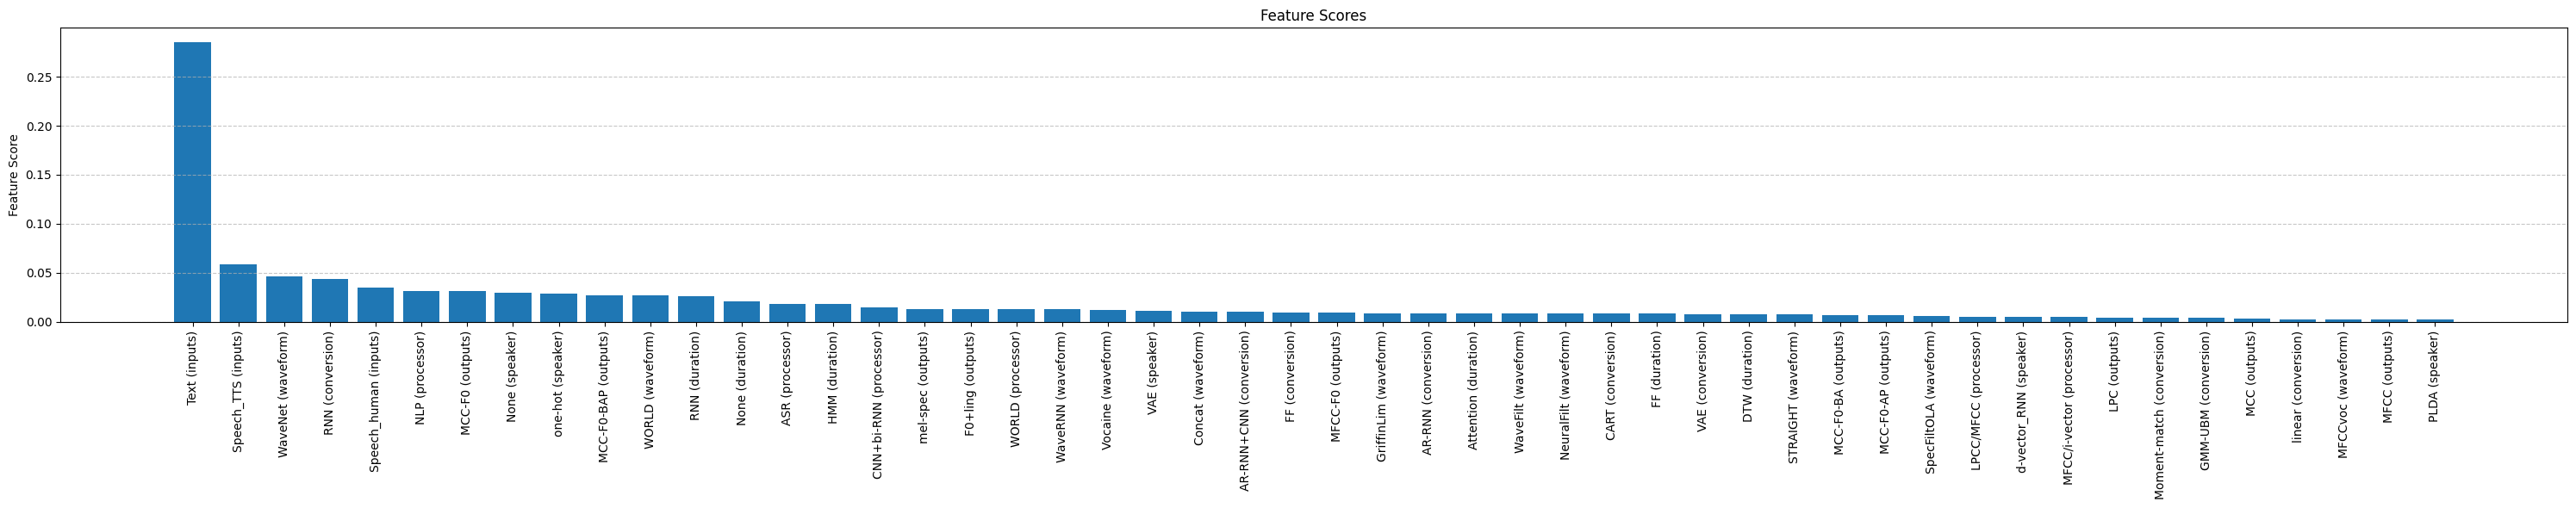

In [27]:
df = pd.DataFrame({'Feature': np.array(in_vars), 'Score': gfi_norm})
df_sorted = df.sort_values(by='Score', ascending=False)

# Plot
plt.figure(figsize=(30, 6))
plt.bar(df_sorted['Feature'], df_sorted['Score'])
plt.xticks(rotation=90)
plt.ylabel('Feature Score')
plt.title('Feature Scores')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [37]:
gfi_by_class = np.abs(shap_FI).mean(axis=0).T    # (F, C) -> transpose -> (C, F) = (17, 50)
# (tuỳ chọn) chuẩn hoá theo hàng (mỗi lớp tổng = 1)
gfi_by_class_norm = gfi_by_class / (gfi_by_class.sum(axis=1, keepdims=True) + 1e-12)

In [38]:
gfi_by_class_norm.shape

(17, 50)

In [39]:
def plot_inFeature_importance(shap_scores, outNode_id):
    scores = shap_scores[outNode_id]

    # Create a DataFrame for sorting
    df = pd.DataFrame({'Feature': np.array(in_vars), 'Score': scores})
    df_sorted = df.sort_values(by='Score', ascending=False)
    
    # Plot
    plt.figure(figsize=(30, 6))
    plt.bar(df_sorted['Feature'], df_sorted['Score'])
    plt.xticks(rotation=90)
    plt.ylabel('Feature Score')
    plt.title('Input feature importance for A0{}'.format(outNode_id+1))
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

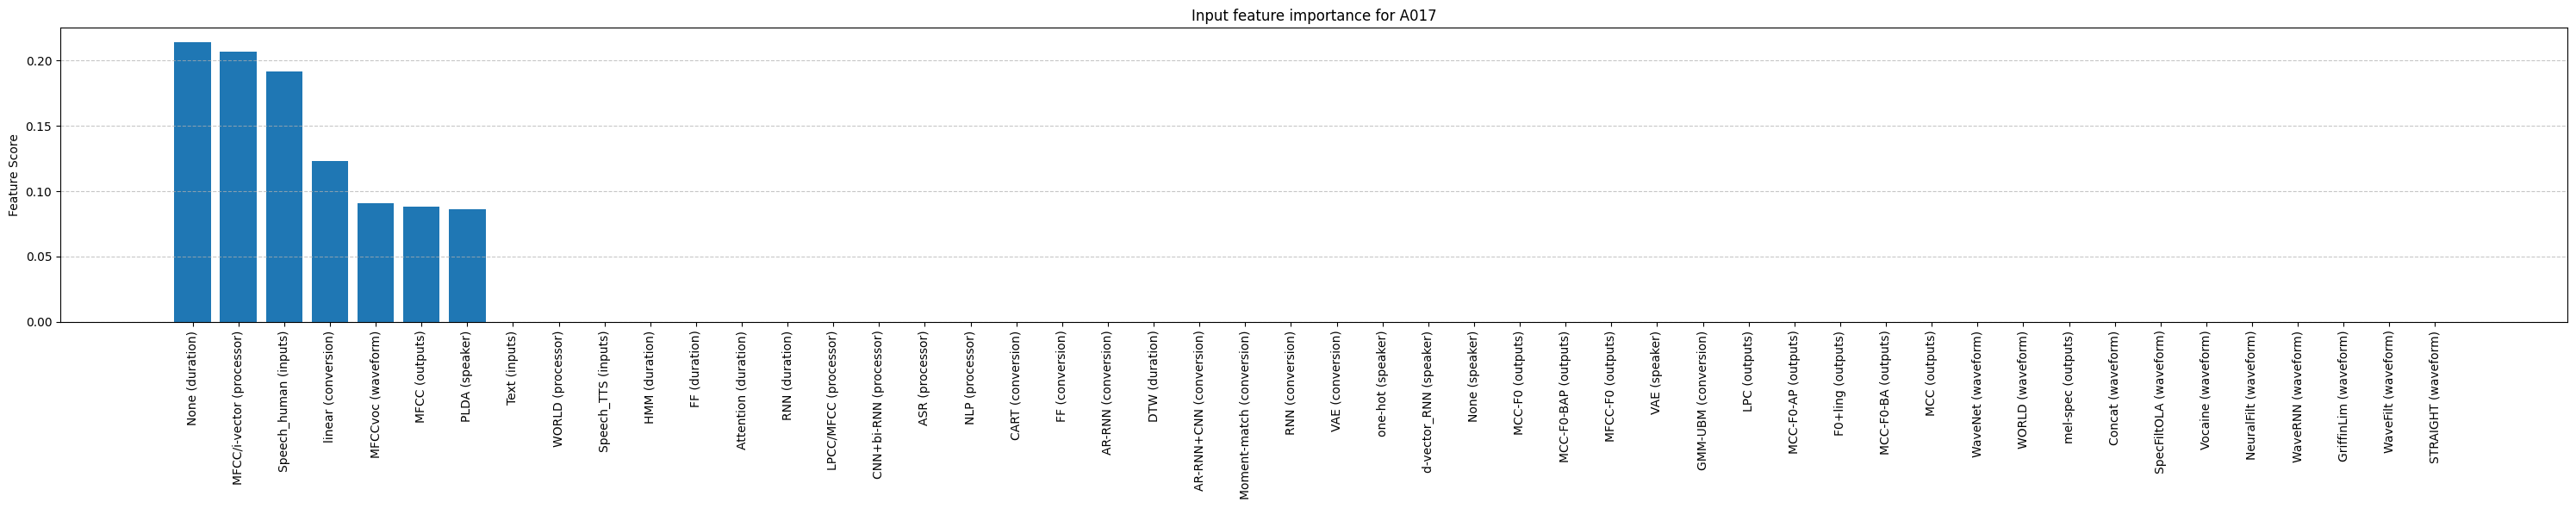

In [40]:
plot_inFeature_importance(gfi_by_class_norm, 16)

#### **Comparing built-in KAN's FI and SHAP's FI**

In [28]:
rank_KAN_builtin_FI= rank_feature_scores(KAN_builtin_FI)
rank_KAN_builtin_FI

array([ 1, 17, 10, 14, 27, 47, 28, 15, 45, 12, 44, 26, 50, 38, 13, 24, 23,
       46, 19, 41,  4, 42, 39, 43,  7,  9, 49, 34,  8,  2,  5, 37, 21, 36,
       25, 29, 32, 30, 31,  6,  3, 35, 33, 16, 18, 40, 20, 11, 22, 48])

In [29]:
rank_SHAP_FI = rank_feature_scores(gfi_norm)
rank_SHAP_FI

array([ 1,  5,  2,  6, 19, 40, 16, 14, 42, 15, 33, 12, 29, 35, 13, 28, 25,
       32, 34, 45,  4, 24, 44, 47, 22,  9, 41, 50,  8,  7, 10, 26, 38, 43,
       37, 17, 18, 46, 49,  3, 11, 23, 39, 31, 21, 20, 27, 30, 36, 48])

In [30]:
list_ranks = np.array([rank_KAN_builtin_FI, rank_SHAP_FI])
M = spearman_pairwise(list_ranks)
M

array([[1.        , 0.72398559],
       [0.72398559, 1.        ]])

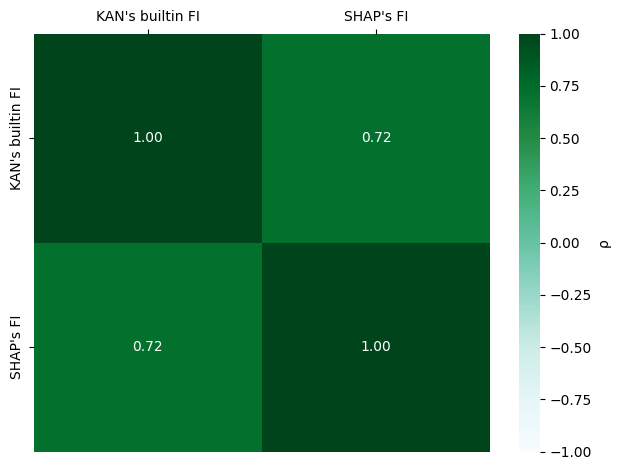

In [33]:
plot_corr_matrix(M, names=["KAN's builtin FI", "SHAP's FI"], title="")

#### **Per attack's FI**

In [34]:
KAN_builtin_FI_perAtk = get_FI_per_attack(kan_module)

In [35]:
KAN_builtin_FI_perAtk.shape

(17, 50)

In [41]:
list_runs = [KAN_builtin_FI_perAtk, gfi_by_class_norm]

In [42]:
def get_rank_perAtk_multi_runs(attack=0, list_runs=list_runs):
    
    runs_scores = np.array([rank_feature_scores(x[attack]) for x in list_runs]) 

    M = spearman_pairwise(runs_scores, task='per_attack')

    return M

In [43]:
list_M = []
for i in range(17):
    list_M.append(get_rank_perAtk_multi_runs(attack=i))
list_M = np.array(list_M)

In [44]:
list_M.shape

(17, 2, 2)

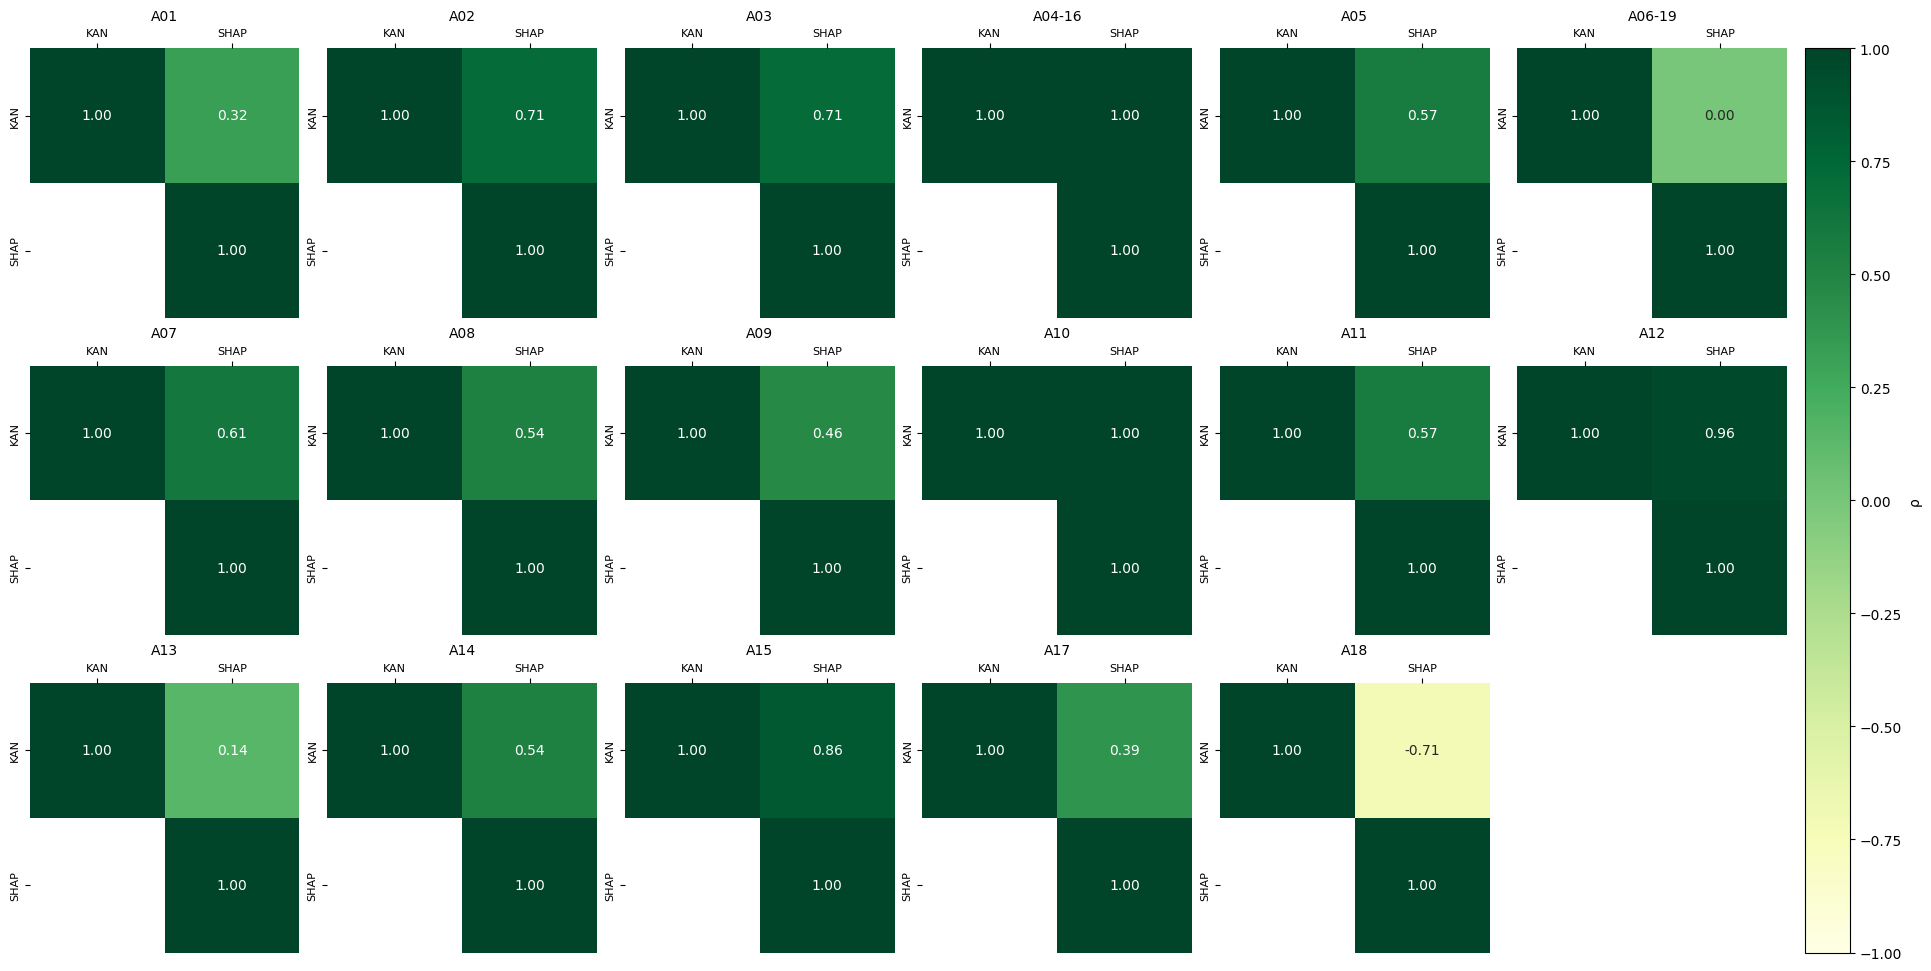

In [45]:
plot_corr_grid(list_M,
               titles=["A01", "A02", "A03", "A04-16", "A05", "A06-19", "A07", "A08", "A09", "A10", "A11", "A12", "A13", "A14", "A15", "A17", "A18"],
               seed_labels=["KAN", "SHAP"])

## **Criteria 2: Stability**

In [ ]:
import os
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.cm import ScalarMappable

from tqdm.auto import tqdm

import torch
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

from data_utils import ASVSpoof2019_Attr17_attack_attribute_structure
from model import CMMTLKAN
from FI_utils import *

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import balanced_accuracy_score

from itertools import combinations


#### utils

In [4]:
def eval_AttackCls(loader, model, device):

    model.eval()

    total_acc = 0.0
    
    all_true = []
    all_pred = []
    
    total = 0

    with torch.no_grad():
        for embeddings, attack_labels in tqdm(loader):
            
            embeddings = embeddings.to(device)
            attack_labels = attack_labels.to(device)
            
            AttackCls_outputs = model(embeddings)
            
            total += embeddings.shape[0]
            
            AttackCls_probs = F.softmax(AttackCls_outputs, dim=-1) # [B, n_attack_types]
            pred_AttackCls = AttackCls_probs.argmax(dim=-1)  # [B]
            AttackCls_acc = (pred_AttackCls == attack_labels).float().sum().item()  # acc for 1 batch of #n_spoof_samples_in_a_batch
            total_acc += AttackCls_acc
            
            # used for balanced accuracy
            pred_AttackCls = pred_AttackCls.cpu().numpy()
            true_AttackCls = attack_labels.cpu().numpy()
            all_pred.extend(pred_AttackCls)
            all_true.extend(true_AttackCls)
            
    avg_acc = total_acc / total
    
    # balanced accuracy
    avg_balanced_acc = balanced_accuracy_score(all_true, all_pred)

    attCls_cfsMatrix = confusion_matrix(all_true, all_pred)
    attCls_clsReport = classification_report(all_true, all_pred, digits=3)
    
    return avg_acc, avg_balanced_acc, attCls_cfsMatrix, attCls_clsReport 

In [5]:
in_vars=["Text (inputs)", "Speech_human (inputs)", "Speech_TTS (inputs)",
         "NLP (processor)", "WORLD (processor)", "LPCC/MFCC (processor)", "CNN+bi-RNN (processor)", "ASR (processor)", "MFCC/i-vector (processor)",
         "HMM (duration)", "FF (duration)", "RNN (duration)", "Attention (duration)", "DTW (duration)", "None (duration)", 
         "AR-RNN (conversion)", "FF (conversion)", "CART (conversion)", "VAE (conversion)", "GMM-UBM (conversion)", "RNN (conversion)", "AR-RNN+CNN (conversion)", "Moment-match (conversion)", "linear (conversion)",
         "VAE (speaker)", "one-hot (speaker)", "d-vector_RNN (speaker)", "PLDA (speaker)", "None (speaker)", 
         "MCC-F0 (outputs)", "MCC-F0-BAP (outputs)", "MFCC-F0 (outputs)", "MCC-F0-AP (outputs)", "LPC (outputs)", "MCC-F0-BA (outputs)", "mel-spec (outputs)", "F0+ling (outputs)", "MCC (outputs)", "MFCC (outputs)",
         "WaveNet (waveform)", "WORLD (waveform)", "Concat (waveform)", "SpecFiltOLA (waveform)", "NeuralFilt (waveform)", "Vocaine (waveform)", "WaveRNN (waveform)", "GriffinLim (waveform)", "WaveFilt (waveform)", "STRAIGHT (waveform)", "MFCCvoc (waveform)"
        ]
out_vars=['A01', 'A02', 'A03', 'A04-16', 'A05', 'A06-19', 'A07', 'A08', 'A09', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A17', 'A18']

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


### **evaluating whole data's FI**

In [7]:
embds_folder = "./extracted_embds"
exp_name = "ST_RB_AASIST_MTL_KANaux_trainingScratch"
exp_folder = os.path.join(embds_folder, exp_name)

eval_attackAttr_embeddings_file = "ASVspoof2019_attr17_eval_attackAttr_embeddings.npy"

In [8]:
eval_attackAttr_embeddings_path = os.path.join(exp_folder, eval_attackAttr_embeddings_file)

In [9]:
eval_attackAttr_embeddings = np.load(eval_attackAttr_embeddings_path)
eval_attackAttr_embeddings.shape

(47880, 50)

In [10]:
eval_protocols_path = './data/ASVspoof2019_attr17_cm_protocols/Eval_ASVspoof19_attr17.txt'
eval_attack_labels = load_attack_labels(eval_protocols_path)

In [11]:
eval_dataset = AttClsDataset(eval_attackAttr_embeddings, eval_attack_labels)

In [12]:
eval_loader = DataLoader(eval_dataset,
                             batch_size=len(eval_dataset),
                             shuffle=False,
                             drop_last=False,
                             pin_memory=True,
                             collate_fn=None,
                             num_workers=8)
print("Number of batches in eval loader: ", len(eval_loader))

Number of batches in eval loader:  1


In [13]:
pretrained_path = "./weights/best_ST_RB_AASIST_MTL_KANaux_trainingScratch.pt"
    
model = CMMTLKAN(
                backbone="AASIST",
                use_pretrained_backbone=False,
                freeze_backbone=False,
                device=device, 
                kan_auxiliary_structure=ASVSpoof2019_Attr17_attack_attribute_structure,
                seed=42
            ).to(device)
model.load_state_dict(torch.load(pretrained_path, map_location=device))
# model.kan_module.module_inFeatures(structure)

nb_params = sum([param.view(-1).size()[0] for param in model.parameters()])
print("no. model params:{}".format(nb_params))

Adding modular structure for KAN
no. model params:492444


In [14]:
kan_module = model.kan_module
# kan_module.module_inFeatures(structure)
kan_module.to(device)

MultKAN(
  (act_fun): ModuleList(
    (0): KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
)

In [65]:
def get_fi_per_bs(loader, model):
    
    model.eval()

    per_samples_features_scores = []
    with torch.no_grad():
        for embeddings, _ in tqdm(loader):
            
            embeddings = embeddings.to(device)
            
            AttackCls_outputs = model(embeddings)

            feature_scores = model.feature_score

            feature_scores = feature_scores.detach().cpu().numpy()
        
            per_samples_features_scores.append(feature_scores)

    per_samples_features_scores = np.array(per_samples_features_scores)
    print(per_samples_features_scores.shape)

    std_FI_by_samples = np.std(per_samples_features_scores, axis=0)

    return std_FI_by_samples 

In [33]:
FI_bs1 = get_fi_per_bs(eval_loader, kan_module)
rank_FI_bs1 = rank_feature_scores(FI_bs1)
print(rank_FI_bs1)

  0%|          | 0/47880 [00:40<?, ?it/s]

(47880, 50)
[ 1  2  9  8 12 41  7 37 43 28 32  5 16 48  6 30 18 50 23 40  4 31 46 44
 27  3 10 42 11 26 22 49 15 38 29 19 14 47 39 20 17 45 33 24 21 36 13 35
 25 34]


In [39]:
FI_bs8 = get_fi_per_bs(eval_loader, kan_module)
rank_FI_bs8 = rank_feature_scores(FI_bs8)
print(rank_FI_bs8)

  0%|          | 0/5985 [00:00<?, ?it/s]

(5985, 50)
[ 1  2  4  8 18 44 32 14 42 15 34 17 50 43  7 27 20 48 24 41  9 46 37 47
 13  5 45 38  3  6 11 35 28 29 22 33 19 23 30 10 12 36 40 31 21 39 25 16
 26 49]


In [44]:
FI_bs32 = get_fi_per_bs(eval_loader, kan_module)
rank_FI_bs32 = rank_feature_scores(FI_bs32)
print(rank_FI_bs32)

  0%|          | 0/1497 [00:00<?, ?it/s]

(1497, 50)
[ 1  2  5  9 16 42 30 14 43 15 33 17 48 37  7 27 20 50 19 39  8 46 41 49
 13  6 44 38  3  4 12 35 32 31 26 34 18 25 29 10 11 36 40 28 22 45 24 21
 23 47]


In [49]:
FI_bs64 = get_fi_per_bs(eval_loader, kan_module)
rank_FI_bs64 = rank_feature_scores(FI_bs64)
print(rank_FI_bs64)

  0%|          | 0/749 [00:00<?, ?it/s]

(749, 50)
[ 1  2  7  9 16 41 30 14 44 15 32 17 48 37  6 27 20 50 18 39  8 46 42 49
 13  5 43 38  3  4 12 35 33 31 26 34 19 25 29 10 11 36 40 28 22 45 24 21
 23 47]


In [54]:
FI_bs256 = get_fi_per_bs(eval_loader, kan_module)
rank_FI_bs256 = rank_feature_scores(FI_bs256)
print(rank_FI_bs256)

  0%|          | 0/188 [00:00<?, ?it/s]

(188, 50)
[ 1  2  8  9 14 42 31 15 40 13 23 17 47 27  7 28 21 50 18 39  5 48 45 49
 16  6 44 36  4  3 12 37 33 34 30 35 20 26 32 10 11 38 41 24 25 46 29 22
 19 43]


In [ ]:
eval_avg_acc, eval_avg_balanced_acc, attCls_cfsMatrix, attCls_clsReport = eval_AttackCls(eval_loader, kan_module, device)

In [67]:
global_FI = kan_module.feature_score.detach().cpu().numpy()
global_FI

array([0.20562686, 0.03405593, 0.04245324, 0.03617182, 0.02231999,
       0.0103405 , 0.02076587, 0.03514146, 0.01164321, 0.03897751,
       0.01164634, 0.02355151, 0.00633507, 0.01404929, 0.03701304,
       0.02465292, 0.0250267 , 0.01152082, 0.0292038 , 0.01229984,
       0.05129093, 0.01184083, 0.01361861, 0.01171748, 0.04847642,
       0.04377294, 0.00864215, 0.01590724, 0.04545281, 0.05985686,
       0.0512073 , 0.01531271, 0.02655103, 0.01547225, 0.02456337,
       0.01789828, 0.0160277 , 0.01757327, 0.01736732, 0.0495399 ,
       0.05634766, 0.01560541, 0.01595636, 0.03417489, 0.02999453,
       0.01270396, 0.02717767, 0.04080744, 0.0257196 , 0.01014895],
      dtype=float32)

In [68]:
rank_global_FI = rank_feature_scores(global_FI)
rank_global_FI

array([ 1, 17, 10, 14, 27, 47, 28, 15, 45, 12, 44, 26, 50, 38, 13, 24, 23,
       46, 19, 41,  4, 42, 39, 43,  7,  9, 49, 34,  8,  2,  5, 37, 21, 36,
       25, 29, 32, 30, 31,  6,  3, 35, 33, 16, 18, 40, 20, 11, 22, 48])

In [73]:
list_ranks = np.array([rank_global_FI, rank_FI_bs1, rank_FI_bs8, rank_FI_bs32, rank_FI_bs64, rank_FI_bs256])
M = spearman_pairwise(list_ranks)
M

array([[1.        , 0.56081633, 0.91702281, 0.91404562, 0.9117407 ,
        0.88408163],
       [0.56081633, 1.        , 0.63860744, 0.65810324, 0.66012005,
        0.64187275],
       [0.91702281, 0.63860744, 1.        , 0.98818727, 0.98578631,
        0.95265306],
       [0.91404562, 0.65810324, 0.98818727, 1.        , 0.99932773,
        0.98031212],
       [0.9117407 , 0.66012005, 0.98578631, 0.99932773, 1.        ,
        0.98165666],
       [0.88408163, 0.64187275, 0.95265306, 0.98031212, 0.98165666,
        1.        ]])

In [75]:
def plot_corr_matrix(M, names=None, title="Spearman rank correlation"):
    m = len(M)
    if names is None: names = [f"V{i+1}" for i in range(m)]
    df = pd.DataFrame(M, index=names, columns=names)
    # mask = np.tril(np.ones_like(df, dtype=bool), k=-1)  # hide strictly lower
    ax = sns.heatmap(df, vmin=-1, vmax=1, annot=True, fmt=".2f",
                     cbar_kws={'label': 'ρ'}, cmap='BuGn')
    ax.set_title(title)
    ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
    plt.tight_layout()
    plt.show()

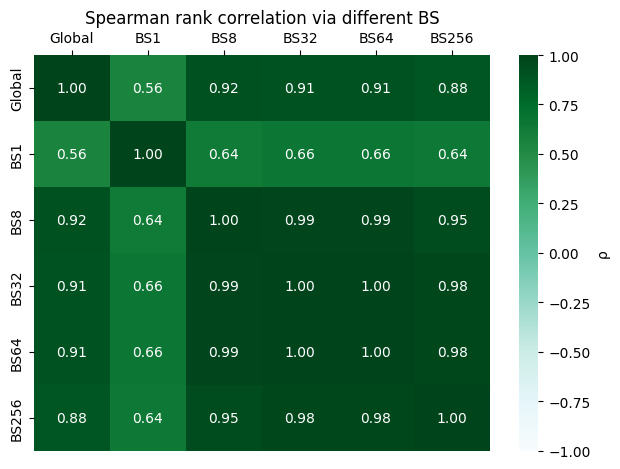

In [76]:
plot_corr_matrix(M, names=["Global", "BS1", "BS8", "BS32", "BS64", "BS256"], title="Spearman rank correlation via different BS")

#### per attack's FI

In [77]:
def get_FI_per_attack(kan_model):

    all_scores = []
    for i in range(17):
        scores = kan_model.attribute(1, i, plot=False).detach().cpu().numpy()
        all_scores.append(scores)

    return np.array(all_scores)

In [142]:
embds_folder = "./extracted_embds"
exp_name = "ST_RB_AASIST_MTL_KANaux_trainingScratch"
exp_folder = os.path.join(embds_folder, exp_name)

eval_attackAttr_embeddings_file = "ASVspoof2019_attr17_eval_attackAttr_embeddings.npy"

In [143]:
eval_attackAttr_embeddings_path = os.path.join(exp_folder, eval_attackAttr_embeddings_file)

In [144]:
eval_attackAttr_embeddings = np.load(eval_attackAttr_embeddings_path)
eval_attackAttr_embeddings.shape

(47880, 50)

In [145]:
eval_protocols_path = './data/ASVspoof2019_attr17_cm_protocols/Eval_ASVspoof19_attr17.txt'
eval_attack_labels = load_attack_labels(eval_protocols_path)

In [146]:
eval_dataset = AttClsDataset(eval_attackAttr_embeddings, eval_attack_labels)

In [147]:
eval_loader = DataLoader(eval_dataset,
                             batch_size=256,
                             shuffle=False,
                             drop_last=False,
                             pin_memory=True,
                             collate_fn=None,
                             num_workers=8)
print("Number of batches in eval loader: ", len(eval_loader))

Number of batches in eval loader:  188


In [148]:
pretrained_path = "./weights/best_ST_RB_AASIST_MTL_KANaux_trainingScratch.pt"
    
model = CMMTLKAN(
                backbone="AASIST",
                use_pretrained_backbone=False,
                freeze_backbone=False,
                device=device, 
                kan_auxiliary_structure=ASVSpoof2019_Attr17_attack_attribute_structure,
                seed=42
            ).to(device)
model.load_state_dict(torch.load(pretrained_path, map_location=device))
# model.kan_module.module_inFeatures(structure)

nb_params = sum([param.view(-1).size()[0] for param in model.parameters()])
print("no. model params:{}".format(nb_params))

Adding modular structure for KAN
no. model params:492444


In [149]:
kan_module = model.kan_module
# kan_module.module_inFeatures(structure)
kan_module.to(device)

MultKAN(
  (act_fun): ModuleList(
    (0): KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
)

In [150]:
def get_fi_per_bs_by_attack(loader, model):
    
    model.eval()

    per_samples_features_scores = []
    with torch.no_grad():
        for embeddings, _ in tqdm(loader):
            
            embeddings = embeddings.to(device)
            
            AttackCls_outputs = model(embeddings)

            feature_scores = get_FI_per_attack(model)

            per_samples_features_scores.append(feature_scores)

    per_samples_features_scores = np.array(per_samples_features_scores)
    print(per_samples_features_scores.shape)

    if per_samples_features_scores.shape[0] == 1:
        return per_samples_features_scores[0]

    std_FI_by_samples = np.std(per_samples_features_scores, axis=0)

    return std_FI_by_samples 

In [99]:
global_perAtk_FI = get_fi_per_bs_by_attack(eval_loader, kan_module)
global_perAtk_FI.shape

  0%|          | 0/1 [00:00<?, ?it/s]

(1, 17, 50)


(17, 50)

In [107]:
FI_perAtk_bs1 = get_fi_per_bs_by_attack(eval_loader, kan_module)
FI_perAtk_bs1.shape

  0%|          | 0/47880 [00:00<?, ?it/s]

(47880, 17, 50)


(17, 50)

In [117]:
FI_perAtk_bs8 = get_fi_per_bs_by_attack(eval_loader, kan_module)
FI_perAtk_bs8.shape

  0%|          | 0/5985 [00:00<?, ?it/s]

(5985, 17, 50)


(17, 50)

In [130]:
FI_perAtk_bs32 = get_fi_per_bs_by_attack(eval_loader, kan_module)
FI_perAtk_bs32.shape

  0%|          | 0/1497 [00:00<?, ?it/s]

(1497, 17, 50)


(17, 50)

In [141]:
FI_perAtk_bs64 = get_fi_per_bs_by_attack(eval_loader, kan_module)
FI_perAtk_bs64.shape

  0%|          | 0/749 [00:00<?, ?it/s]

(749, 17, 50)


(17, 50)

In [151]:
FI_perAtk_bs256 = get_fi_per_bs_by_attack(eval_loader, kan_module)
FI_perAtk_bs256.shape

  0%|          | 0/188 [00:00<?, ?it/s]

(188, 17, 50)


(17, 50)

In [152]:
list_runs = [global_perAtk_FI, FI_perAtk_bs1, FI_perAtk_bs8, FI_perAtk_bs32, FI_perAtk_bs64, FI_perAtk_bs256]

In [153]:
def get_rank_perAtk_multi_runs(attack=0, list_runs=list_runs):
    
    ranks_scores = np.array([rank_feature_scores(x[attack]) for x in list_runs]) 

    M = spearman_pairwise(ranks_scores, task='per_attack')

    return M

In [154]:
list_M = []
for i in range(17):
    list_M.append(get_rank_perAtk_multi_runs(attack=i))
list_M = np.array(list_M)
list_M.shape

(17, 6, 6)

In [156]:
def plot_corr_grid(M_list, titles=None, seed_labels=None, upper_only=True,
                   cmap="YlGn", annot=True, fmt=".2f"):
    
    k = len(M_list)
    N = M_list[0].shape[0]
    assert all(M.shape == (N, N) for M in M_list), "All matrices must be same size."

    if titles is None:
        titles = [f"A{i+1:02d}" for i in range(k)]
    if seed_labels is None:
        seed_labels = [str(i+1) for i in range(N)]

    # choose a compact grid
    cols = min(6, k)                    # up to 5 across; adjust if you prefer
    rows = math.ceil(k / cols)

    fig, axes = plt.subplots(rows, cols,
                             figsize=(cols*3.2, rows*3.2),
                             constrained_layout=True)
    axes = np.atleast_1d(axes).ravel()

    vmin, vmax = -1.0, 1.0
    norm = plt.Normalize(vmin=vmin, vmax=vmax)

    for ax, M, title in zip(axes, M_list, titles):
        df = pd.DataFrame(M, index=seed_labels, columns=seed_labels)
        mask = np.tril(np.ones_like(df, dtype=bool), k=-1) if upper_only else None
        sns.heatmap(df, ax=ax, cmap=cmap, vmin=vmin, vmax=vmax,
                    square=True, mask=mask, annot=annot, fmt=fmt,
                    cbar=False)
        ax.set_title(title, pad=6, fontsize=10)
        ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False, labelsize=8)

    # hide any unused axes
    for ax in axes[len(M_list):]:
        ax.axis("off")

    # one shared colorbar
    sm = ScalarMappable(norm=norm, cmap=cmap); sm.set_array([])
    cbar = fig.colorbar(sm, ax=axes[:len(M_list)], fraction=0.03, pad=0.01)
    cbar.set_label("ρ")

    plt.show()

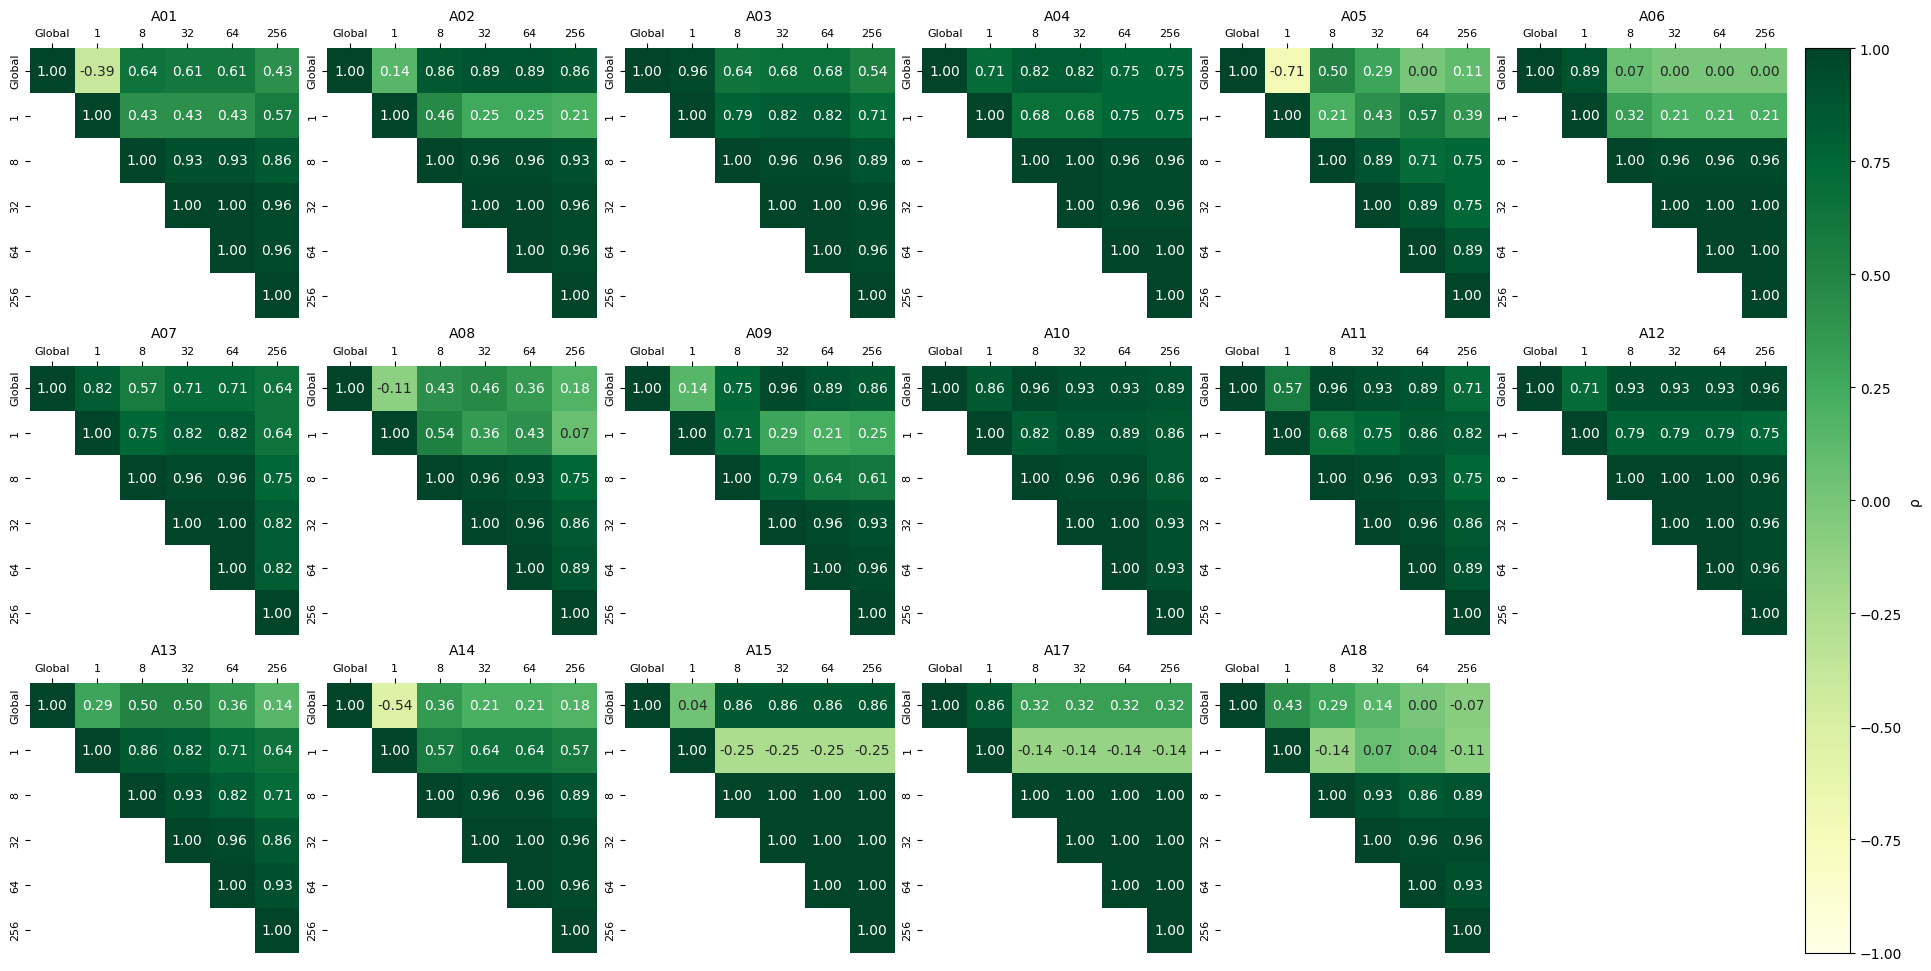

In [157]:
plot_corr_grid(list_M,
               titles=["A01", "A02", "A03", "A04", "A05", "A06", "A07", "A08", "A09", "A10", "A11", "A12", "A13", "A14", "A15", "A17", "A18"],
               seed_labels=["Global", "1", "8", "32", "64", "256"])

## **Criteria 3: Faithfulness**

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

import torch
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

from data_utils import ASVSpoof2019_Attr17_attack_attribute_structure
from model import CMMTLKAN
from FI_utils import *

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import balanced_accuracy_score


#### **eval_phase function**

In [4]:
def eval_AttackCls(loader, model, device):

    model.eval()

    total_acc = 0.0
    
    all_true = []
    all_pred = []
    
    total = 0

    with torch.no_grad():
        for embeddings, attack_labels in tqdm(loader):
            
            embeddings = embeddings.to(device)
            attack_labels = attack_labels.to(device)
            
            AttackCls_outputs = model(embeddings)
            
            total += embeddings.shape[0]
            
            AttackCls_probs = F.softmax(AttackCls_outputs, dim=-1) # [B, n_attack_types]
            pred_AttackCls = AttackCls_probs.argmax(dim=-1)  # [B]
            AttackCls_acc = (pred_AttackCls == attack_labels).float().sum().item()  # acc for 1 batch of #n_spoof_samples_in_a_batch
            total_acc += AttackCls_acc
            
            # used for balanced accuracy
            pred_AttackCls = pred_AttackCls.cpu().numpy()
            true_AttackCls = attack_labels.cpu().numpy()
            all_pred.extend(pred_AttackCls)
            all_true.extend(true_AttackCls)
            
    avg_acc = total_acc / total
    
    # balanced accuracy
    avg_balanced_acc = balanced_accuracy_score(all_true, all_pred)

    attCls_cfsMatrix = confusion_matrix(all_true, all_pred)
    attCls_clsReport = classification_report(all_true, all_pred, digits=3)
    
    return avg_acc, avg_balanced_acc, attCls_cfsMatrix, attCls_clsReport 

In [5]:
def plot_cfm(cm, class_names):
    # Normalize per row (for per-class accuracy view)
    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # Plot
    plt.figure(figsize=(12, 12))
    sns.heatmap(cm_normalized, annot=True, cmap="BuPu",
                xticklabels=class_names,
                yticklabels=class_names,
                fmt=".2f")
    
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    # plt.title("Normalized Confusion Matrix (Per class Accuracy - %)")
    plt.show()

In [6]:
in_vars=["Text (inputs)", "Speech_human (inputs)", "Speech_TTS (inputs)",
         "NLP (processor)", "WORLD (processor)", "LPCC/MFCC (processor)", "CNN+bi-RNN (processor)", "ASR (processor)", "MFCC/i-vector (processor)",
         "HMM (duration)", "FF (duration)", "RNN (duration)", "Attention (duration)", "DTW (duration)", "None (duration)", 
         "AR-RNN (conversion)", "FF (conversion)", "CART (conversion)", "VAE (conversion)", "GMM-UBM (conversion)", "RNN (conversion)", "AR-RNN+CNN (conversion)", "Moment-match (conversion)", "linear (conversion)",
         "VAE (speaker)", "one-hot (speaker)", "d-vector_RNN (speaker)", "PLDA (speaker)", "None (speaker)", 
         "MCC-F0 (outputs)", "MCC-F0-BAP (outputs)", "MFCC-F0 (outputs)", "MCC-F0-AP (outputs)", "LPC (outputs)", "MCC-F0-BA (outputs)", "mel-spec (outputs)", "F0+ling (outputs)", "MCC (outputs)", "MFCC (outputs)",
         "WaveNet (waveform)", "WORLD (waveform)", "Concat (waveform)", "SpecFiltOLA (waveform)", "NeuralFilt (waveform)", "Vocaine (waveform)", "WaveRNN (waveform)", "GriffinLim (waveform)", "WaveFilt (waveform)", "STRAIGHT (waveform)", "MFCCvoc (waveform)"
        ]
out_vars=['A01', 'A02', 'A03', 'A04-16', 'A05', 'A06-19', 'A07', 'A08', 'A09', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A17', 'A18']

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


#### **Evaluating (Necessity + Sufficiency)**

In [31]:
structure = [
    ([0], [1, 3, 9, 11]),
    ([7], [14]),
    ([16], [2]),
    ([24], [0]),
    ([32], [4]),
    ([37], [12]),
    ([38], [16]),
    ([40], [6]),
    ([42], [5]),
    ([43], [7]),
    ([44], [8]),
    ([46], [10]),
    ([47], [15]),
    ([48], [13]),
]

In [32]:
embds_folder = "./extracted_embds"
exp_name = "ST_RB_AASIST_MTL_KANaux_trainingScratch"
exp_folder = os.path.join(embds_folder, exp_name)

eval_attackAttr_embeddings_file = "ASVspoof2019_attr17_eval_attackAttr_embeddings.npy"

In [33]:
eval_attackAttr_embeddings_path = os.path.join(exp_folder, eval_attackAttr_embeddings_file)

In [34]:
eval_attackAttr_embeddings = np.load(eval_attackAttr_embeddings_path)
eval_attackAttr_embeddings.shape

(47880, 50)

In [35]:
eval_protocols_path = './data/ASVspoof2019_attr17_cm_protocols/Eval_ASVspoof19_attr17.txt'

eval_attack_labels = load_attack_labels(eval_protocols_path)

In [36]:
eval_dataset = AttClsDataset(eval_attackAttr_embeddings, eval_attack_labels)

In [37]:
eval_loader = DataLoader(eval_dataset,
                             batch_size=len(eval_dataset),
                             shuffle=False,
                             drop_last=False,
                             pin_memory=True,
                             collate_fn=None,
                             num_workers=8)
print("Number of batches in eval loader: ", len(eval_loader))

Number of batches in eval loader:  1


In [38]:
pretrained_path = "./weights/best_ST_RB_AASIST_MTL_KANaux_trainingScratch.pt"
    
model = CMMTLKAN(
                backbone="AASIST",
                use_pretrained_backbone=False,
                freeze_backbone=False,
                device=device, 
                kan_auxiliary_structure=ASVSpoof2019_Attr17_attack_attribute_structure,
                seed=42
            ).to(device)
model.load_state_dict(torch.load(pretrained_path, map_location=device))
# model.kan_module.module_inFeatures(structure)

nb_params = sum([param.view(-1).size()[0] for param in model.parameters()])
print("no. model params:{}".format(nb_params))

Adding modular structure for KAN
no. model params:492444


In [39]:
kan_module = model.kan_module
kan_module.module_inFeatures(structure)
kan_module.to(device)

Adding modular structure for KAN


MultKAN(
  (act_fun): ModuleList(
    (0): KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
)

In [41]:
eval_avg_acc, eval_avg_balanced_acc, attCls_cfsMatrix, attCls_clsReport = eval_AttackCls(eval_loader, kan_module, device)

  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib64/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib64/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib64/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Evaluation Results:
Average Accuracy: 0.6991854636591479
Average Balanced Accuracy: 0.7328749689080408

Attack Classification Confusion Matrix:


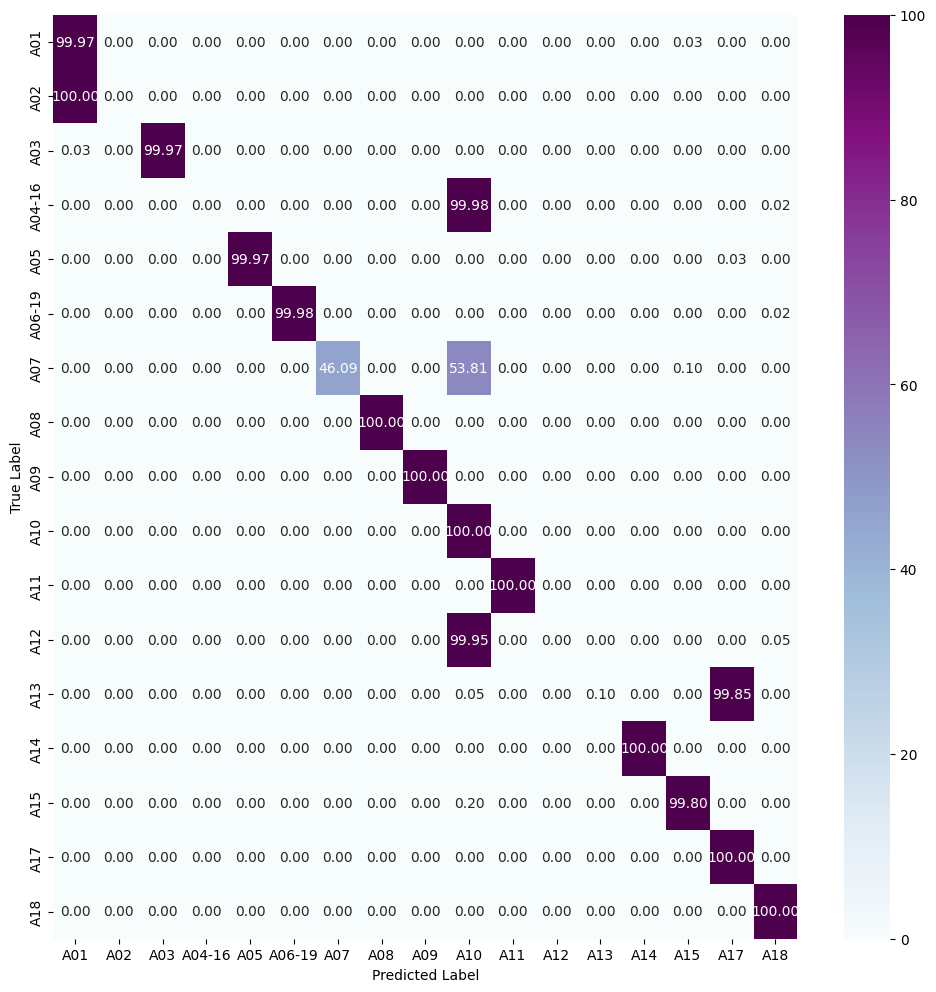


Attack Classification Report:
              precision    recall  f1-score   support

           0      0.500     1.000     0.666      3716
           1      0.000     0.000     0.000      3716
           2      1.000     1.000     1.000      3716
           3      0.000     0.000     0.000      5684
           4      1.000     1.000     1.000      3716
           5      1.000     1.000     1.000      5684
           6      1.000     0.461     0.631      1968
           7      1.000     1.000     1.000      1968
           8      1.000     1.000     1.000      1968
           9      0.184     1.000     0.311      1968
          10      1.000     1.000     1.000      1968
          11      0.000     0.000     0.000      1968
          12      1.000     0.001     0.002      1968
          13      1.000     1.000     1.000      1968
          14      0.998     0.998     0.998      1968
          15      0.500     1.000     0.667      1968
          16      0.998     1.000     0.999      1

In [42]:
print("\nEvaluation Results:")
print("Average Accuracy:", eval_avg_acc)
print("Average Balanced Accuracy:", eval_avg_balanced_acc)
print("\nAttack Classification Confusion Matrix:")
plot_cfm(attCls_cfsMatrix, out_vars)
print("\nAttack Classification Report:")
print(attCls_clsReport)

In [18]:
kan_module.cache_data.shape

torch.Size([47880, 50])

In [19]:
feature_scores = kan_module.feature_score
feature_scores

tensor([0.2056, 0.0341, 0.0425, 0.0362, 0.0223, 0.0103, 0.0208, 0.0351, 0.0116,
        0.0390, 0.0116, 0.0236, 0.0063, 0.0140, 0.0370, 0.0247, 0.0250, 0.0115,
        0.0292, 0.0123, 0.0513, 0.0118, 0.0136, 0.0117, 0.0485, 0.0438, 0.0086,
        0.0159, 0.0455, 0.0599, 0.0512, 0.0153, 0.0266, 0.0155, 0.0246, 0.0179,
        0.0160, 0.0176, 0.0174, 0.0495, 0.0563, 0.0156, 0.0160, 0.0342, 0.0300,
        0.0127, 0.0272, 0.0408, 0.0257, 0.0101], device='cuda:0',
       grad_fn=<MeanBackward1>)

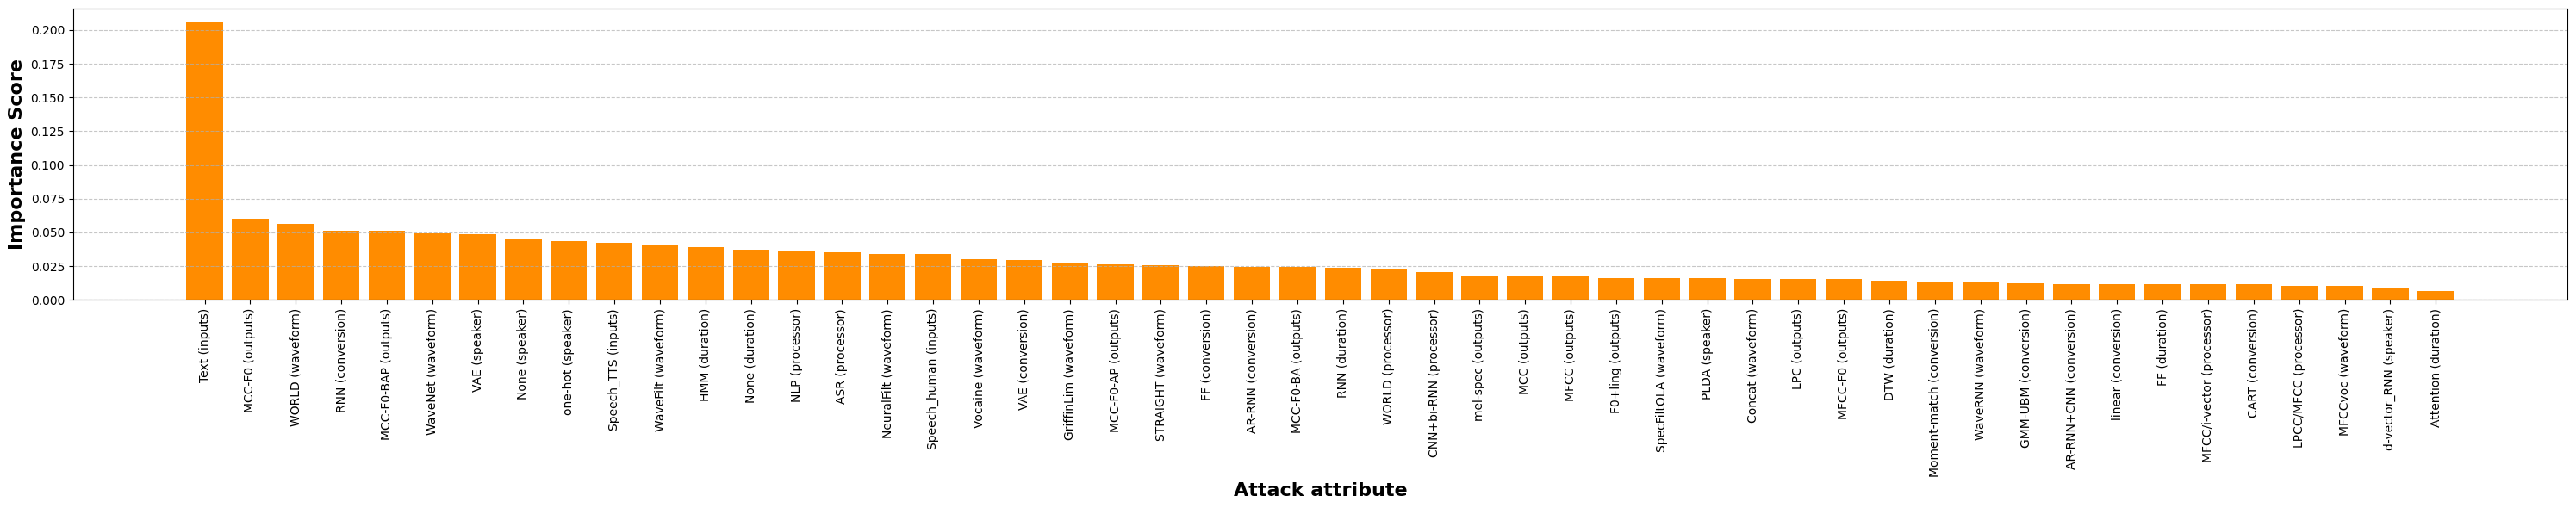

In [27]:
# Create a DataFrame for sorting
df = pd.DataFrame({'Feature': np.array(in_vars), 'Score': feature_scores.detach().cpu().numpy()})
df_sorted = df.sort_values(by='Score', ascending=False)

# Plot
plt.figure(figsize=(30, 6))
plt.bar(df_sorted['Feature'], df_sorted['Score'], color='darkorange')
plt.xticks(rotation=90)
plt.ylabel('Importance Score', fontsize=16, fontweight='bold')
plt.xlabel('Attack attribute', fontsize=16, fontweight='bold')
# plt.title('Feature Scores')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

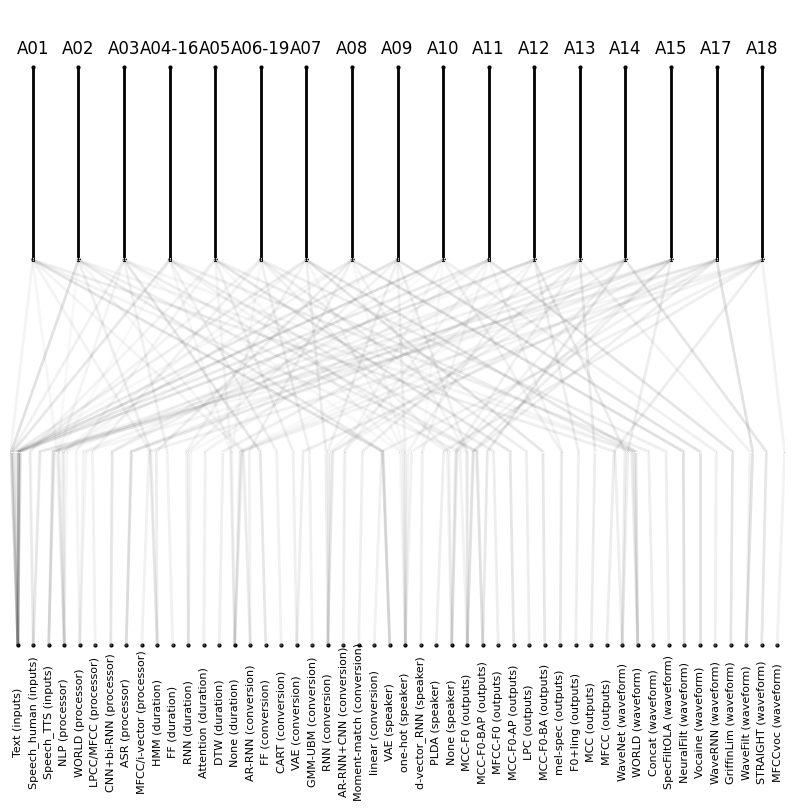

In [49]:
kan_module.plot(beta=3, scale=1, varscale=0.2, in_vars=in_vars, out_vars=out_vars)

In [28]:
def plot_inFeature_importance(kan_model, outNode_id):
    scores = kan_model.attribute(1, outNode_id)

    # Create a DataFrame for sorting
    df = pd.DataFrame({'Feature': np.array(in_vars), 'Score': scores.detach().cpu().numpy()})
    df_sorted = df.sort_values(by='Score', ascending=False)
    
    # Plot
    plt.figure(figsize=(30, 6))
    plt.bar(df_sorted['Feature'], df_sorted['Score'])
    plt.xticks(rotation=90)
    plt.ylabel('Feature Score')
    plt.title('Input feature importance for A0{}'.format(outNode_id+1))
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

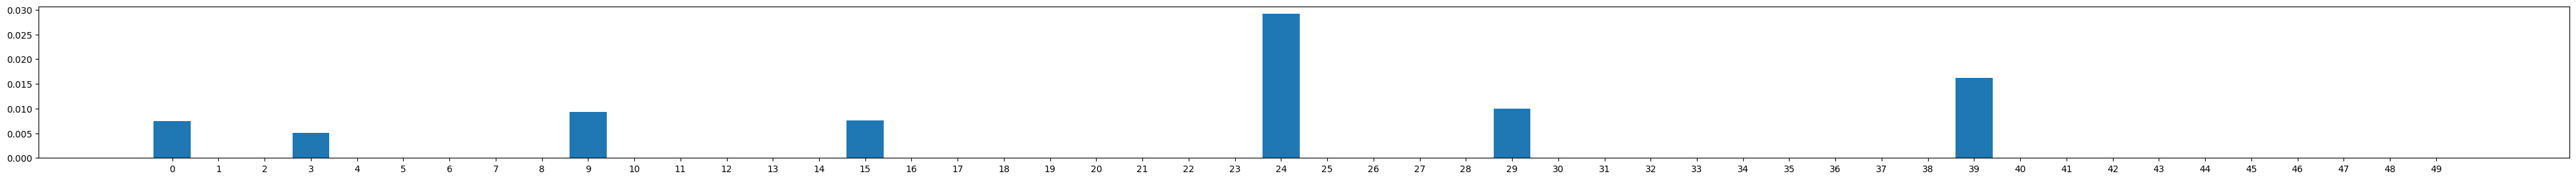

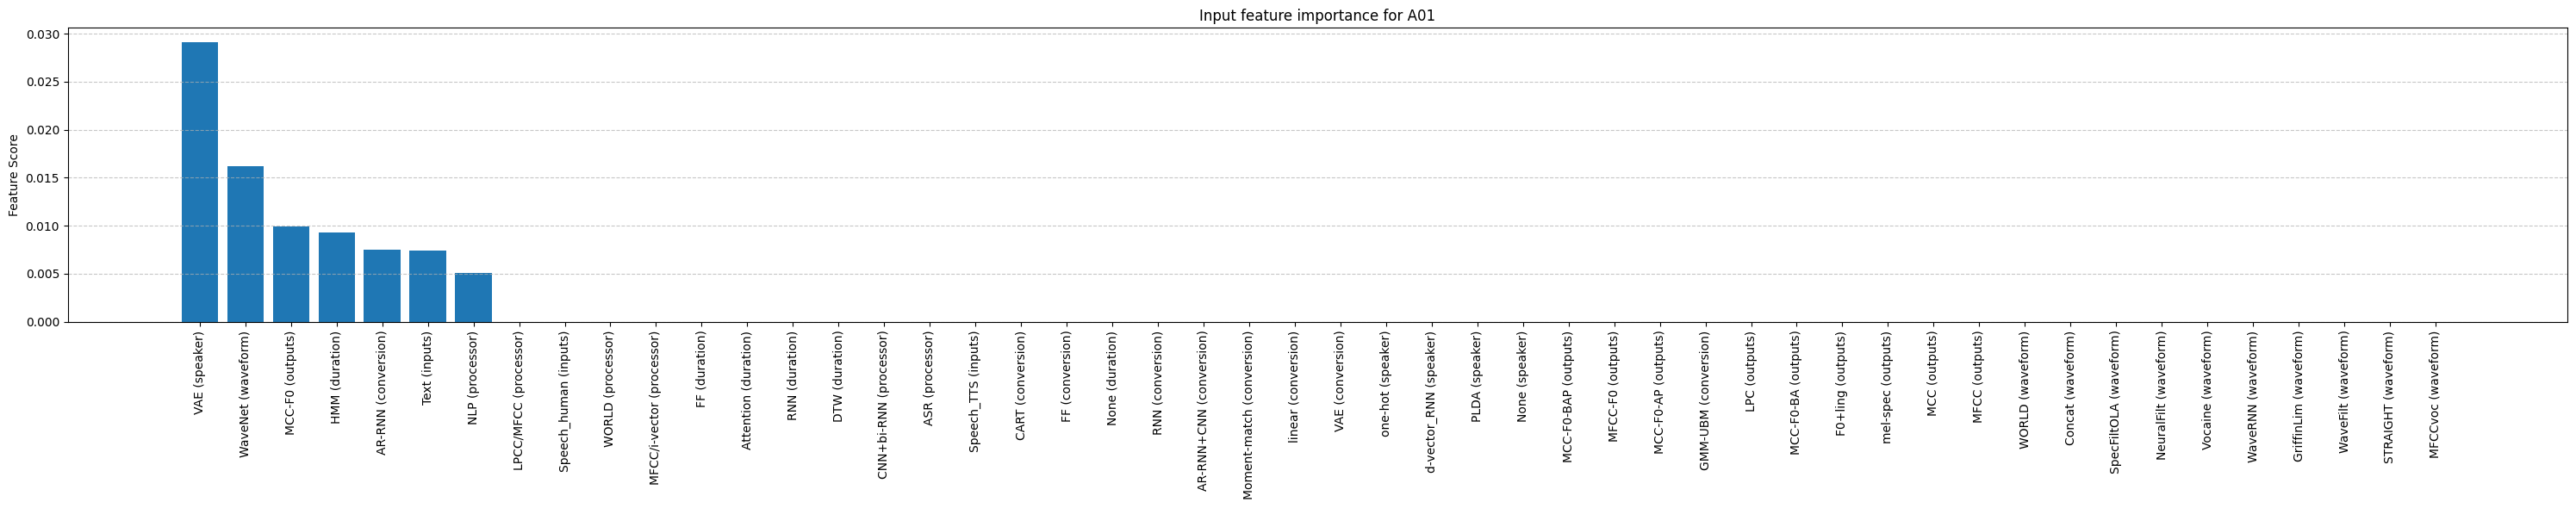

In [31]:
plot_inFeature_importance(kan_module, 0)

In [32]:
most_important_features = []
for i in range(len(out_vars)):
    scores = kan_module.attribute(1, i, plot=False)
    
    # Create a DataFrame for sorting
    df = pd.DataFrame({'Feature': np.array(in_vars), 'Score': scores.detach().cpu().numpy()})
    df_sorted = df.sort_values(by='Score', ascending=False)
    # print()
    # print()
    most_important_features.append(df_sorted['Feature'].values[:7])

df_attack_fi = pd.DataFrame(most_important_features, index=out_vars)

In [33]:
df_attack_fi

,0,1,2,3,4,5,6
A01,VAE (speaker),WaveNet (waveform),MCC-F0 (outputs),HMM (duration),AR-RNN (conversion),Text (inputs),NLP (processor)
A02,Text (inputs),VAE (speaker),HMM (duration),MCC-F0-BAP (outputs),WORLD (waveform),AR-RNN (conversion),NLP (processor)
A03,FF (conversion),MCC-F0-BAP (outputs),Text (inputs),FF (duration),NLP (processor),WORLD (waveform),one-hot (speaker)
A04-16,Text (inputs),Concat (waveform),MFCC-F0 (outputs),CART (conversion),None (speaker),None (duration),NLP (processor)
A05,MCC-F0-AP (outputs),WORLD (waveform),VAE (conversion),WORLD (processor),Speech_human (inputs),None (duration),one-hot (speaker)
A06-19,SpecFiltOLA (waveform),LPC (outputs),GMM-UBM (conversion),LPCC/MFCC (processor),None (speaker),Speech_human (inputs),None (duration)
A07,WORLD (waveform),MCC-F0-BA (outputs),Text (inputs),RNN (conversion),RNN (duration),NLP (processor),one-hot (speaker)
A08,NeuralFilt (waveform),HMM (duration),AR-RNN (conversion),NLP (processor),MCC-F0 (outputs),Text (inputs),one-hot (speaker)
A09,Vocaine (waveform),Text (inputs),MCC-F0 (outputs),RNN (conversion),one-hot (speaker),RNN (duration),NLP (processor)
A10,Text (inputs),WaveRNN (waveform),mel-spec (outputs),CNN+bi-RNN (processor),AR-RNN+CNN (conversion),d-vector_RNN (speaker),Attention (duration)
